# Artificial Neural Networks and Deep Learning

---

## Homework 2

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Load and process the data.
4. Implement and train your model.
5. Submit the generated `.csv` file to Kaggle.


## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/Homework 2

Mounted at /gdrive
/gdrive/My Drive/Homework 2


## ⚙️ Import Libraries

In [ ]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

seed=8
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


## ⏳ Load the Data

In [ ]:
data = np.load("mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)
Input shape: (64, 128, 1)
Number of classes: 5


In [ ]:
# Find the label that all the outliers share
out=y_train[1006-1]
# Search for the indexes of the outliers
l=[]
for i in range(len(y_train)):
  if np.array_equal(out, y_train[i]):
    l.append(i)
print(l)
print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")

# Remove the outliers from the training set
X_train=np.delete(X_train, l, axis=0)
y_train=np.delete(y_train, l, axis=0)

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
Xnoout=X_train
ynoout=y_train

[62, 79, 125, 139, 142, 147, 152, 156, 170, 210, 217, 266, 289, 299, 313, 339, 348, 365, 412, 417, 426, 450, 461, 536, 552, 669, 675, 741, 744, 747, 799, 802, 808, 820, 821, 849, 863, 890, 909, 942, 971, 1005, 1057, 1079, 1082, 1092, 1095, 1106, 1119, 1125, 1177, 1194, 1224, 1247, 1248, 1258, 1261, 1262, 1306, 1324, 1365, 1370, 1443, 1449, 1508, 1509, 1519, 1551, 1584, 1588, 1628, 1637, 1693, 1736, 1767, 1768, 1782, 1813, 1816, 1834, 1889, 1925, 1942, 1975, 1979, 2000, 2002, 2086, 2096, 2110, 2111, 2151, 2161, 2222, 2235, 2239, 2242, 2301, 2307, 2350, 2361, 2365, 2372, 2414, 2453, 2522, 2535, 2561, 2609, 2614]
Training X shape: (2615, 64, 128, 1)
Training y shape: (2615, 64, 128)
Training X shape: (2505, 64, 128, 1)
Training y shape: (2505, 64, 128)


## 🛠️ Train and Save the Model

In [ ]:
# Set batch size for training
BATCH_SIZE = 32 # empirically proven to be better than 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 35

# Set maximum number of training epochs
EPOCHS = 200

# Set data split size for training and validation
SPLITS_SIZE = 180

In [ ]:
# Shuffle the array
indices = np.random.permutation(y_train.shape[0])

X_train = X_train[indices]
y_train = y_train[indices]

In [ ]:
# Count the occurrences of every class
unique_values, counts = np.unique(y_train, return_counts=True)
tot=np.mean(counts)
w=np.zeros(5)

# Print the weights
i=0
for value, count in zip(unique_values, counts):
    print(f"Valore {value}: {count} occorrenze")
    w[i]=tot/count
    i=i+1
print(w)

# Set the weight of class 4 to 5
w[4]=5
print(w)

Valore 0.0: 4988826 occorrenze
Valore 1.0: 6957538 occorrenze
Valore 2.0: 4776810 occorrenze
Valore 3.0: 3770823 occorrenze
Valore 4.0: 26963 occorrenze
[  0.82267692   0.58989142   0.85919097   1.08840749 152.215703  ]
[0.82267692 0.58989142 0.85919097 1.08840749 5.        ]


In [ ]:
# Split the training set in training and validation set
from sklearn.model_selection import train_test_split
print("Splitting data...")
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=SPLITS_SIZE, random_state=seed
)
print("Data splitted!")

print(f"\nNumber of images:")
print(f"Train: {len(X_train)}")
print(f"Validation: {len(X_val)}")

Splitting data...
Data splitted!

Number of images:
Train: 2325
Validation: 180


In [ ]:
# Define the Unet Block
from tensorflow.keras import regularizers
def unet_block(input_tensor, filters, kernel_size, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1),kernel_regularizer=regularizers.l2(0.01))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [ ]:
# Define the model
def get_unet_model2(input_shape=input_shape, num_classes=num_classes, seed=seed, dropout_rate=0.3):
    tf.random.set_seed(seed)
    kernel_size=3
    input_layer = tfkl.Input(shape=input_shape, name='input_layer1')


    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, kernel_size,name='down_block1.2_')
    d1 = tfkl.LayerNormalization(name='norm1')(down_block_1)
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64,kernel_size, name='down_block2.2_')
    d2 = tfkl.LayerNormalization(name='norm2')(down_block_2)
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 128, kernel_size,name='down_block3.2_')
    d3 = tfkl.LayerNormalization(name='norm3')(down_block_3)
    d3 = tfkl.MaxPooling2D()(down_block_3)

    # Bottleneck
    bottleneck = unet_block(d3, 256,kernel_size, name='bottleneck2', )
    # Applying dilated convolutions for capturing a larger receptive field
    bottleneck_dilated = tfkl.Conv2D(256, kernel_size, dilation_rate=2, padding='same', activation='relu')(bottleneck)
    bottleneck_dilated = tfkl.Conv2D(256, kernel_size, dilation_rate=2, padding='same', activation='relu')(bottleneck_dilated)

    # Add residual connection to bottleneck
    bottleneck_residual = tfkl.Add()([bottleneck, bottleneck_dilated])

    u2 = tfkl.UpSampling2D()(bottleneck_residual)
    u2 = tfkl.Concatenate()([u2, down_block_3])
    u2 = tfkl.LayerNormalization(name='norm3b')(u2)
    u2 = unet_block(u2, 128,kernel_size, name='up_block2.2_')
    u2 = tfkl.Dropout(0.2)(u2)

    u3 = tfkl.UpSampling2D()(u2)
    u3 = tfkl.Concatenate()([u3, down_block_2])
    u3 = tfkl.LayerNormalization(name='norm2b')(u3)
    u3 = unet_block(u3, 64,kernel_size, name='up_block3.2_')
    u3 = tfkl.Dropout(0.2)(u3)

    u4 = tfkl.UpSampling2D()(u3)
    u4 = tfkl.Concatenate()([u4, down_block_1])
    u4 = tfkl.LayerNormalization(name='norm1b')(u4)
    u4 = unet_block(u4, 32, kernel_size,name='up_block4.2_')
    u4 = tfkl.Dropout(0.2)(u4)

    # Output Layer: convolutional layer with kernel size 1 and number of filters equals to the number of classes
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer2')(u4)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet2')
    return model

In [ ]:
# Create the model
model2 = get_unet_model2()


In [ ]:
def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

In [ ]:
# Define custom Mean Intersection Over Union metric
#@tf.keras.utils.register_keras_serializable(package="Custom")
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image_path, label_path, frequency=4):
        super().__init__()
        self.image_path = image_path
        self.label_path = label_path
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            # image, label = load_single_image(self.image_path, self.label_path)
            image=self.image_path
            label=self.label_path
            # label = apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            # num_classes = num_classes
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
           # colored_label = apply_colormap(label.numpy(), colormap)
            colored_label = apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [ ]:
# Convert to dictionary or list
class_weights = dict(enumerate(w))
print("Class weights:", class_weights)

Class weights: {0: 0.8226769183771894, 1: 0.5898914242365618, 2: 0.8591909663562084, 3: 1.088407490884616, 4: 5.0}


In [ ]:
#Define the Focal Loss per Sparse Categorical Crossentropy.
import tensorflow.keras.backend as K
#@tf.keras.utils.register_keras_serializable(package="Custom")
def focal_sparse_categorical_crossentropy(y_true, y_pred, gamma=2.0, alpha=np.array(list(class_weights.values()))):


    #Args:
        #y_true: Tensor with real labels (scalar integers, not one-hot).
        #y_pred: Tensor with predicted probabilities  (after softmax).
        #gamma: Modulation factor to stress on difficult examples
        #alpha: Balancing weight for classes (default 0.25 for imbalanced dataset)


    #Returns:
        #Tensor with the computed focal loss.

    # Convert y_true to integer format if necessary
    y_true = tf.cast(y_true, tf.int32)

    # Temporarily apply one-hot encoding to gather probabilities for the correct
    y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])

    # Convert alpha to a tensor and aligns it to the correct shape
    alpha = tf.constant(alpha, dtype=tf.float32)  # Shape: (num_classes,)
    alpha_weights = tf.reduce_sum(y_true_one_hot * alpha, axis=-1)  # Shape: (batch_size,)

    # Get the predicted probabilities for the correct classes
    p_t = tf.reduce_sum(y_true_one_hot * y_pred, axis=-1)  # Shape: (batch_size,)

    # Calculate the focal loss term
    focal_term = alpha_weights * tf.pow(1 - p_t, gamma)

    # Calculate the Sparse Categorical Crossentropy
    loss = -tf.math.log(tf.clip_by_value(p_t, K.epsilon(), 1.0))

    # Combine with the focal term
    focal_loss = focal_term * loss

    return tf.reduce_mean(focal_loss)



In [ ]:
# Compile the model
print("Compiling model...")
model2.compile(
    loss=focal_sparse_categorical_crossentropy,
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=num_classes,labels_to_exclude=[0])]
)
print("Model2 compiled!")

Compiling model...
Model2 compiled!


In [ ]:
#Shuffle the array
indices = np.random.permutation(y_train.shape[0])
X_train = X_train[indices]
y_train = y_train[indices]

In [ ]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback1 = VizCallback(X_val[4], y_val[4])
viz_callback2 = VizCallback(X_val[6], y_val[6])

Epoch 1/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.3335 - loss: 9.4247 - mean_iou: 0.1512

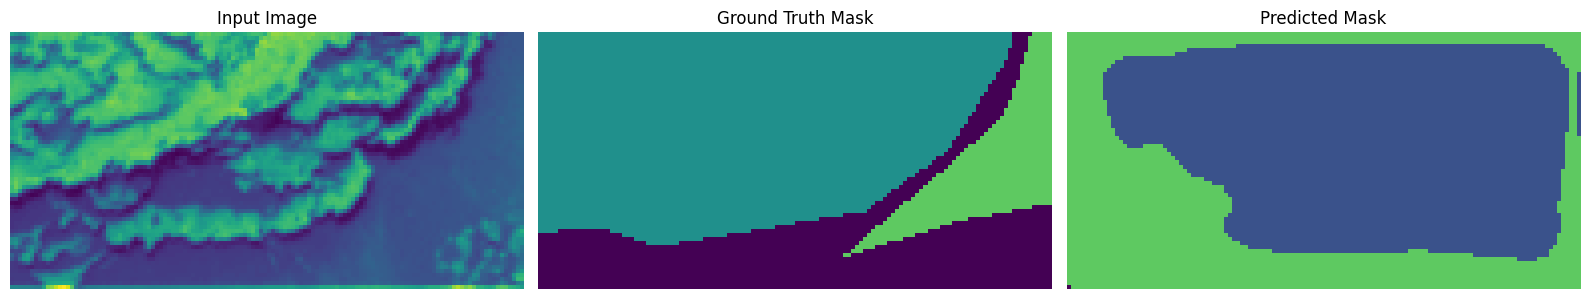

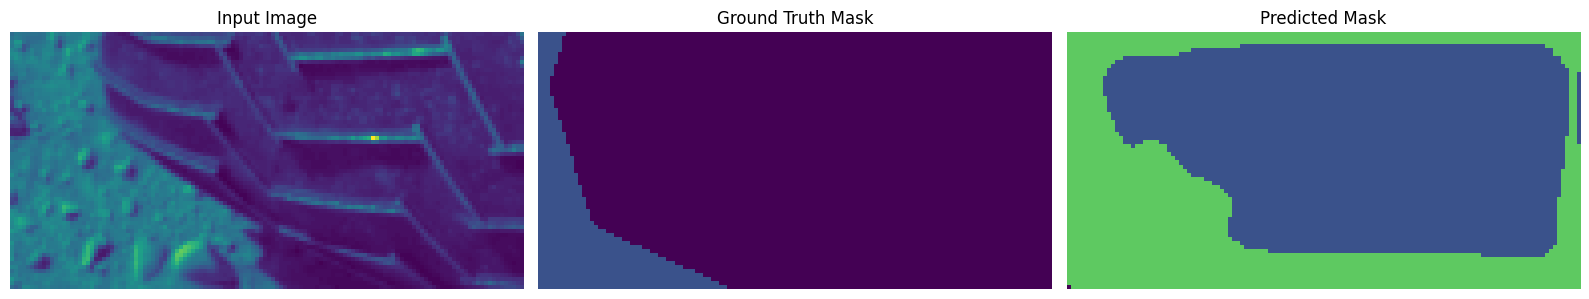

73/73 ━━━━━━━━━━━━━━━━━━━━ 83s 623ms/step - accuracy: 0.3340 - loss: 9.3792 - mean_iou: 0.1514 - val_accuracy: 0.2950 - val_loss: 2.5728 - val_mean_iou: 0.1070 - learning_rate: 0.0010
Epoch 2/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 0.4074 - loss: 1.7734 - mean_iou: 0.1944 - val_accuracy: 0.1837 - val_loss: 1.5051 - val_mean_iou: 0.0476 - learning_rate: 0.0010
Epoch 3/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.4264 - loss: 1.0872 - mean_iou: 0.2039 - val_accuracy: 0.3590 - val_loss: 1.2509 - val_mean_iou: 0.0918 - learning_rate: 0.0010
Epoch 4/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.3909 - loss: 1.0144 - mean_iou: 0.1857 - val_accuracy: 0.1837 - val_loss: 1.3324 - val_mean_iou: 0.0476 - learning_rate: 0.0010
Epoch 5/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.4019 - loss: 0.8414 - mean_iou: 0.1937

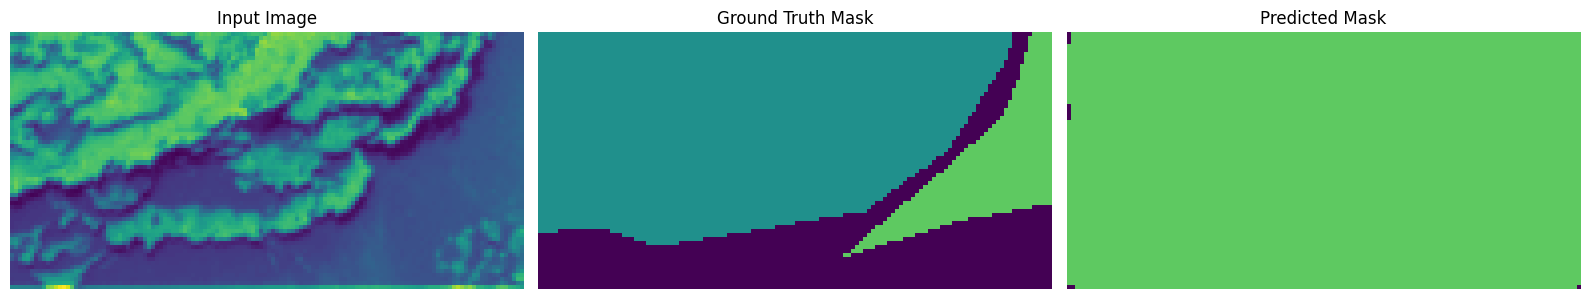

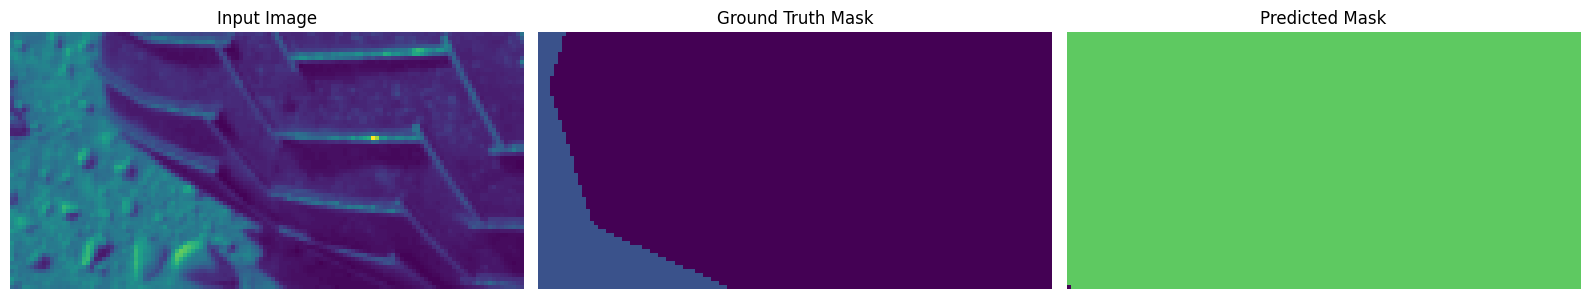

73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.4021 - loss: 0.8409 - mean_iou: 0.1938 - val_accuracy: 0.1845 - val_loss: 1.6262 - val_mean_iou: 0.0476 - learning_rate: 0.0010
Epoch 6/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.4661 - loss: 0.7374 - mean_iou: 0.2338 - val_accuracy: 0.2469 - val_loss: 0.9815 - val_mean_iou: 0.0859 - learning_rate: 0.0010
Epoch 7/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.5102 - loss: 0.7133 - mean_iou: 0.2751 - val_accuracy: 0.3949 - val_loss: 0.9628 - val_mean_iou: 0.1571 - learning_rate: 0.0010
Epoch 8/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.5527 - loss: 0.6949 - mean_iou: 0.3107 - val_accuracy: 0.3696 - val_loss: 0.9687 - val_mean_iou: 0.1603 - learning_rate: 0.0010
Epoch 9/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5462 - loss: 0.6493 - mean_iou: 0.2996

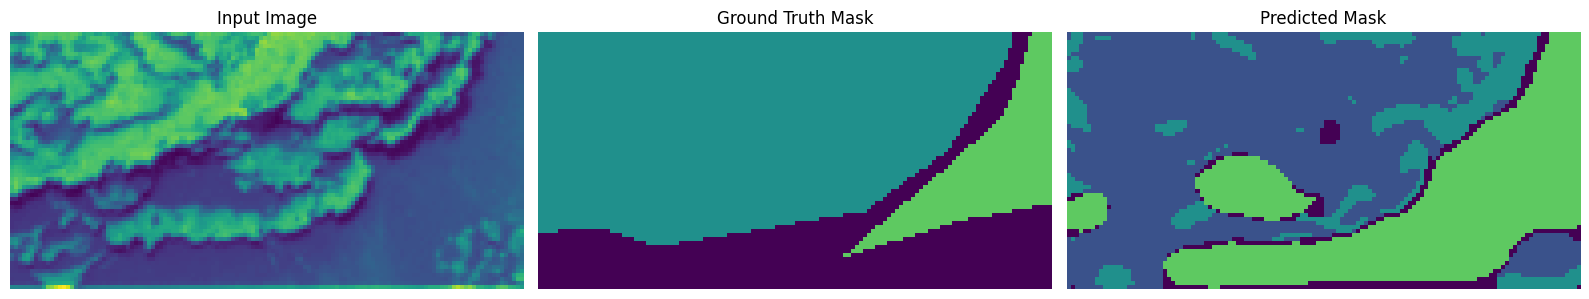

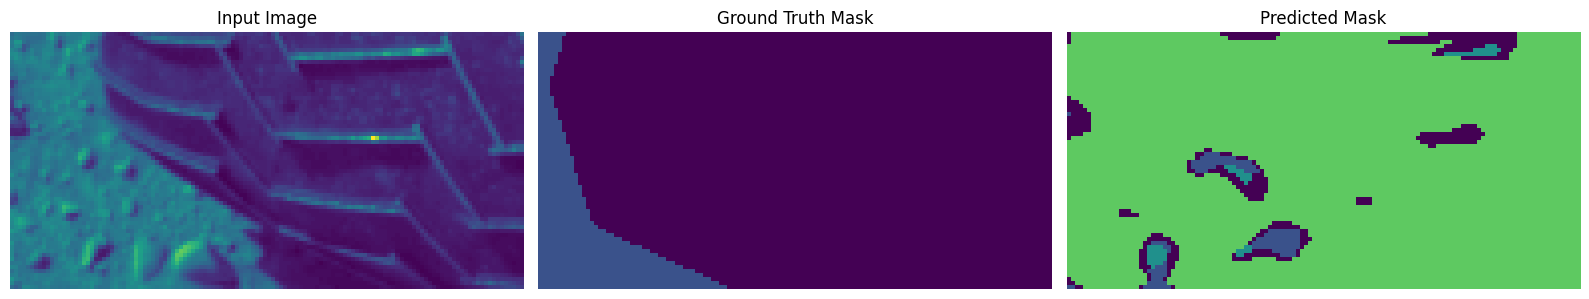

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.5462 - loss: 0.6491 - mean_iou: 0.2997 - val_accuracy: 0.3656 - val_loss: 0.8799 - val_mean_iou: 0.1658 - learning_rate: 0.0010
Epoch 10/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.5433 - loss: 0.6388 - mean_iou: 0.3019 - val_accuracy: 0.5421 - val_loss: 0.6093 - val_mean_iou: 0.2978 - learning_rate: 0.0010
Epoch 11/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.5593 - loss: 0.6091 - mean_iou: 0.3295 - val_accuracy: 0.5659 - val_loss: 0.6110 - val_mean_iou: 0.2881 - learning_rate: 0.0010
Epoch 12/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.5869 - loss: 0.5618 - mean_iou: 0.3460 - val_accuracy: 0.5161 - val_loss: 0.6566 - val_mean_iou: 0.2434 - learning_rate: 0.0010
Epoch 13/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5980 - loss: 0.5651 - mean_iou: 0.3527

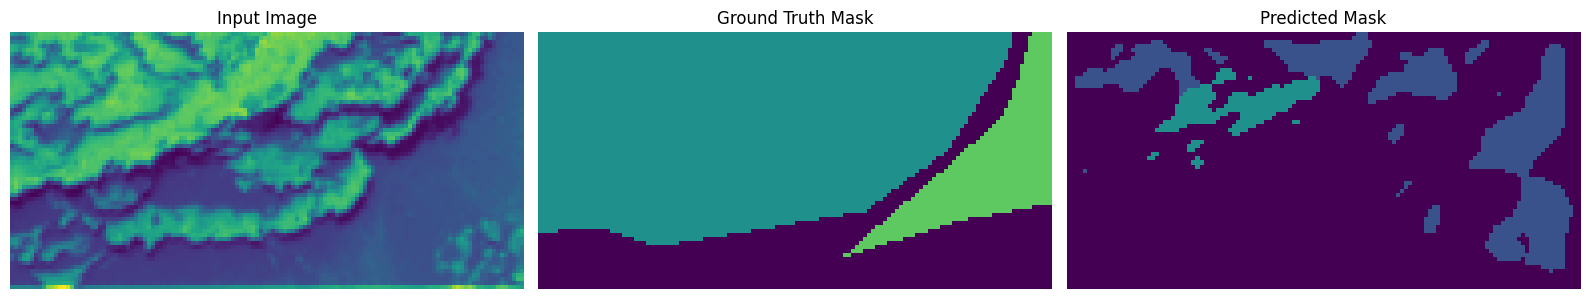

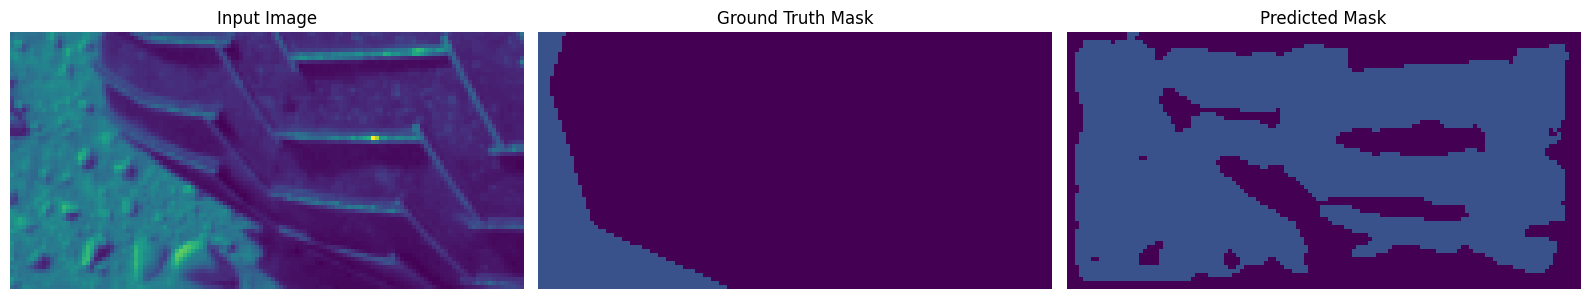

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.5980 - loss: 0.5654 - mean_iou: 0.3527 - val_accuracy: 0.4568 - val_loss: 0.8214 - val_mean_iou: 0.1392 - learning_rate: 0.0010
Epoch 14/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.5969 - loss: 0.5799 - mean_iou: 0.3519 - val_accuracy: 0.5270 - val_loss: 0.6488 - val_mean_iou: 0.2434 - learning_rate: 0.0010
Epoch 15/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.5988 - loss: 0.5492 - mean_iou: 0.3566 - val_accuracy: 0.3864 - val_loss: 0.8144 - val_mean_iou: 0.1438 - learning_rate: 0.0010
Epoch 16/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.5821 - loss: 0.5637 - mean_iou: 0.3441 - val_accuracy: 0.4265 - val_loss: 0.6436 - val_mean_iou: 0.1515 - learning_rate: 0.0010
Epoch 17/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5919 - loss: 0.5609 - mean_iou: 0.3484

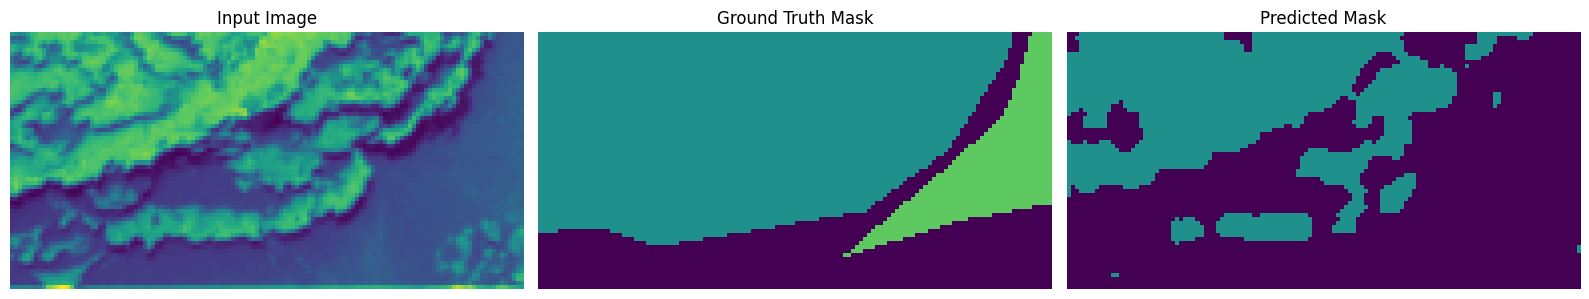

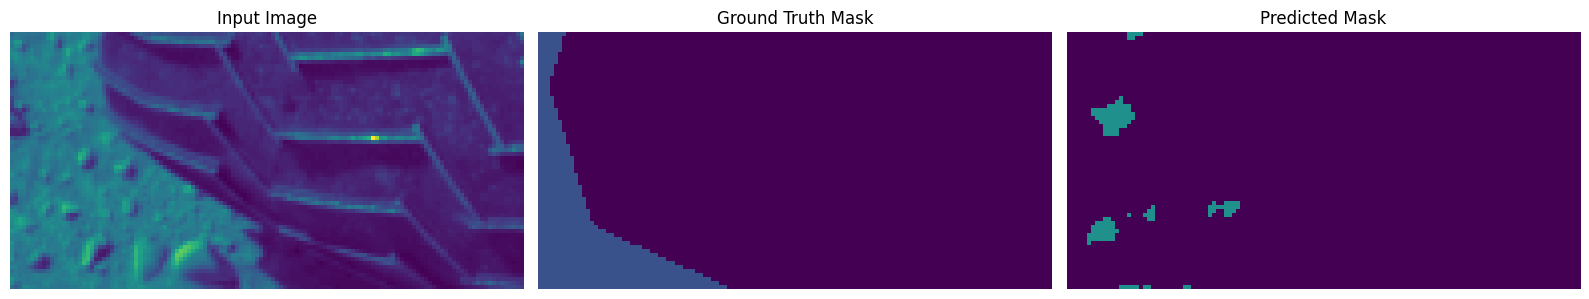

73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.5920 - loss: 0.5610 - mean_iou: 0.3484 - val_accuracy: 0.3421 - val_loss: 0.8311 - val_mean_iou: 0.0789 - learning_rate: 0.0010
Epoch 18/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.5955 - loss: 0.5438 - mean_iou: 0.3598 - val_accuracy: 0.4606 - val_loss: 0.6102 - val_mean_iou: 0.2016 - learning_rate: 0.0010
Epoch 19/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.6130 - loss: 0.5298 - mean_iou: 0.3762 - val_accuracy: 0.4263 - val_loss: 0.7936 - val_mean_iou: 0.1922 - learning_rate: 0.0010
Epoch 20/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.6005 - loss: 0.5639 - mean_iou: 0.3631 - val_accuracy: 0.3035 - val_loss: 1.1638 - val_mean_iou: 0.0872 - learning_rate: 0.0010
Epoch 21/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5652 - loss: 0.6229 - mean_iou: 0.3275

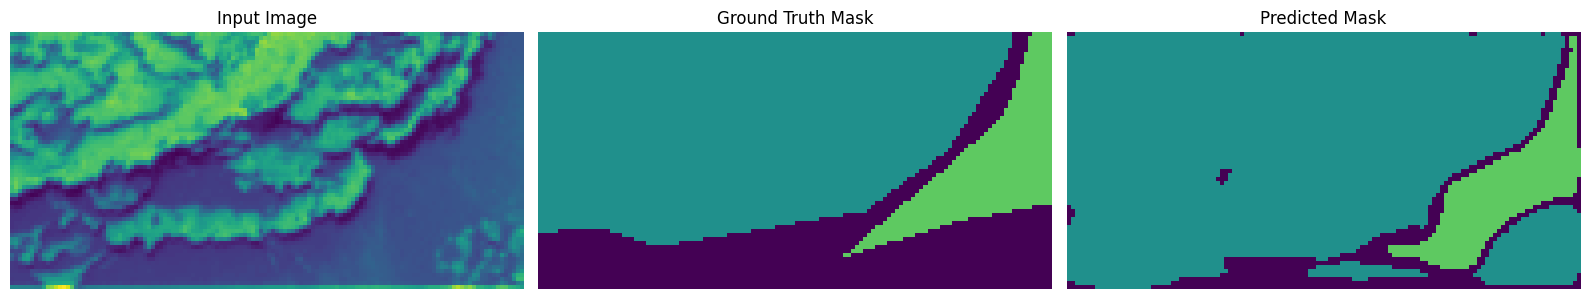

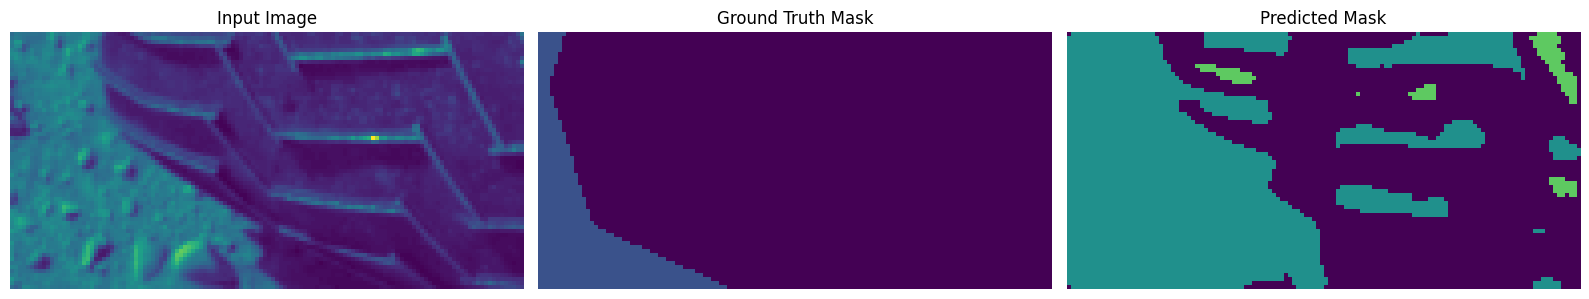

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.5656 - loss: 0.6224 - mean_iou: 0.3278 - val_accuracy: 0.3730 - val_loss: 0.7542 - val_mean_iou: 0.1864 - learning_rate: 0.0010
Epoch 22/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.5887 - loss: 0.5801 - mean_iou: 0.3454 - val_accuracy: 0.5198 - val_loss: 0.6945 - val_mean_iou: 0.2437 - learning_rate: 0.0010
Epoch 23/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.6321 - loss: 0.4944 - mean_iou: 0.3854 - val_accuracy: 0.4266 - val_loss: 0.6302 - val_mean_iou: 0.1504 - learning_rate: 5.0000e-04
Epoch 24/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.6443 - loss: 0.4553 - mean_iou: 0.3935 - val_accuracy: 0.4424 - val_loss: 0.6600 - val_mean_iou: 0.1871 - learning_rate: 5.0000e-04
Epoch 25/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6372 - loss: 0.4680 - mean_iou: 0.3858

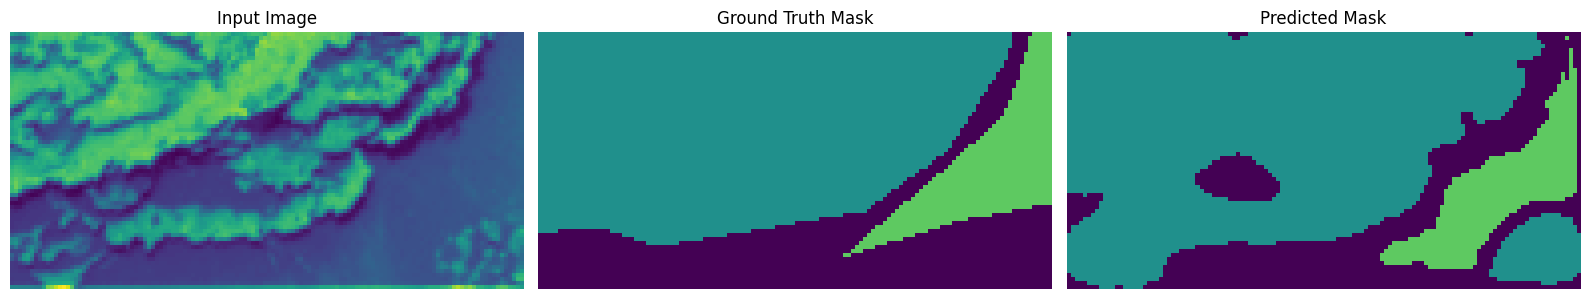

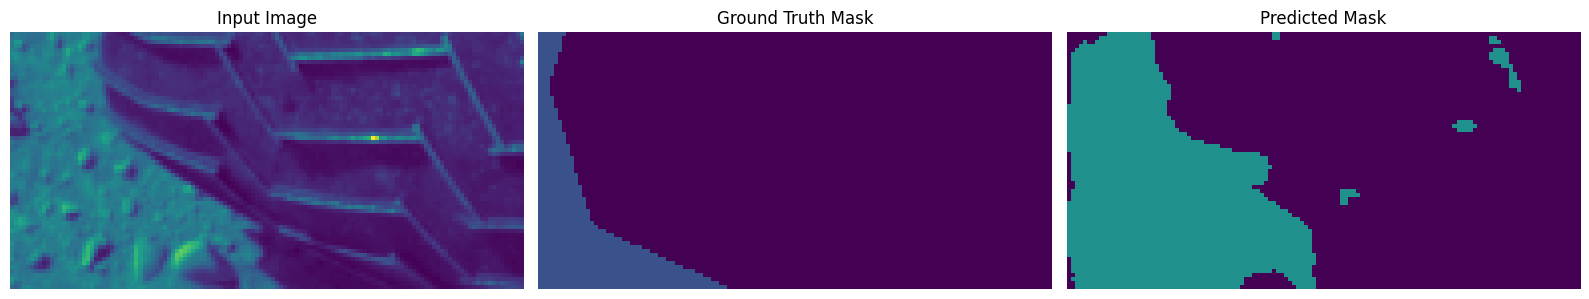

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.6371 - loss: 0.4681 - mean_iou: 0.3857 - val_accuracy: 0.4406 - val_loss: 0.7299 - val_mean_iou: 0.2038 - learning_rate: 5.0000e-04
Epoch 26/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.6264 - loss: 0.4756 - mean_iou: 0.3730 - val_accuracy: 0.4995 - val_loss: 0.5617 - val_mean_iou: 0.2395 - learning_rate: 5.0000e-04
Epoch 27/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.6379 - loss: 0.4547 - mean_iou: 0.3866 - val_accuracy: 0.6109 - val_loss: 0.5072 - val_mean_iou: 0.3378 - learning_rate: 5.0000e-04
Epoch 28/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.6301 - loss: 0.4623 - mean_iou: 0.3783 - val_accuracy: 0.4426 - val_loss: 0.7248 - val_mean_iou: 0.2330 - learning_rate: 5.0000e-04
Epoch 29/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.6406 - loss: 0.4521 - mean_iou: 0.3927

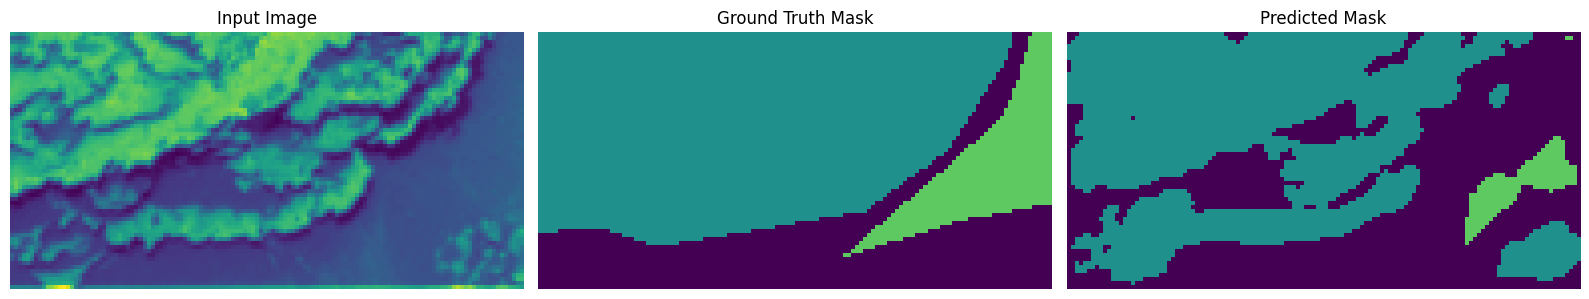

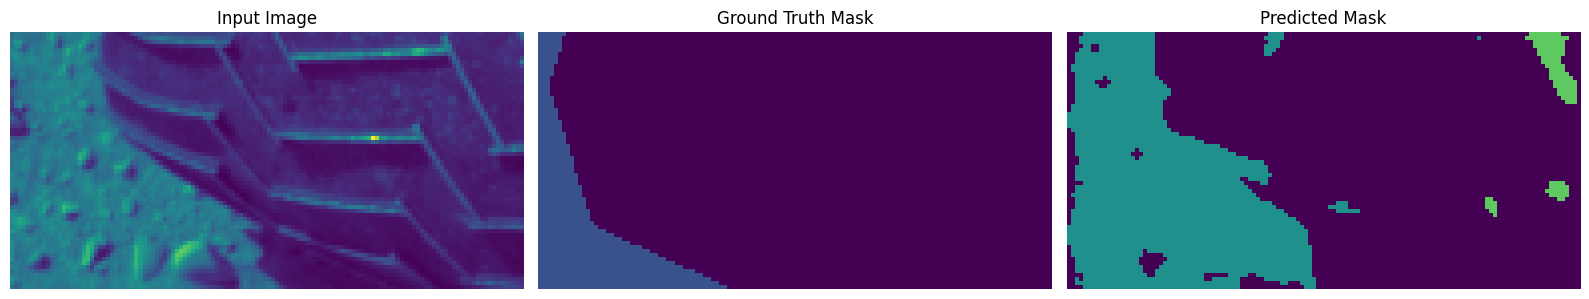

73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.6406 - loss: 0.4521 - mean_iou: 0.3927 - val_accuracy: 0.4227 - val_loss: 0.7320 - val_mean_iou: 0.1920 - learning_rate: 5.0000e-04
Epoch 30/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.6412 - loss: 0.4539 - mean_iou: 0.3880 - val_accuracy: 0.5315 - val_loss: 0.5540 - val_mean_iou: 0.2955 - learning_rate: 5.0000e-04
Epoch 31/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.6244 - loss: 0.4739 - mean_iou: 0.3766 - val_accuracy: 0.5396 - val_loss: 0.5637 - val_mean_iou: 0.2965 - learning_rate: 5.0000e-04
Epoch 32/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.5486 - loss: 0.6184 - mean_iou: 0.3142 - val_accuracy: 0.4719 - val_loss: 0.6038 - val_mean_iou: 0.2318 - learning_rate: 5.0000e-04
Epoch 33/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.6277 - loss: 0.4943 - mean_iou: 0.3766

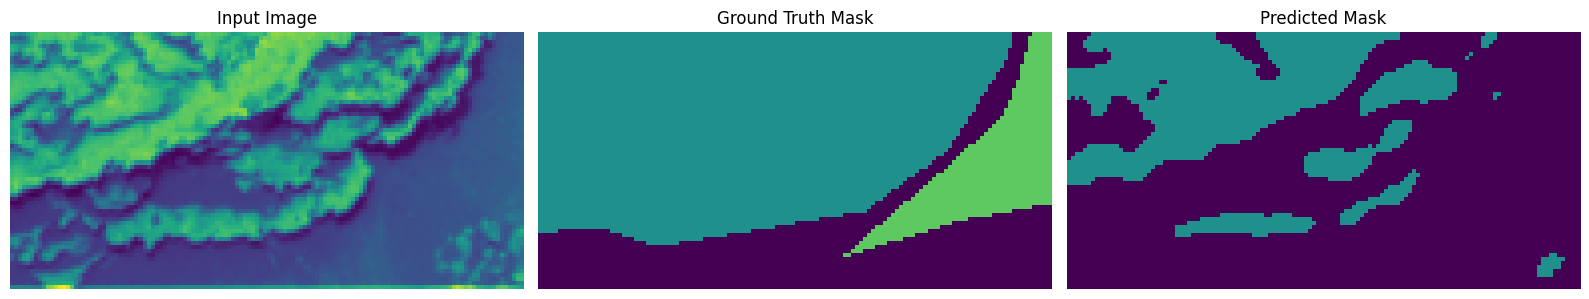

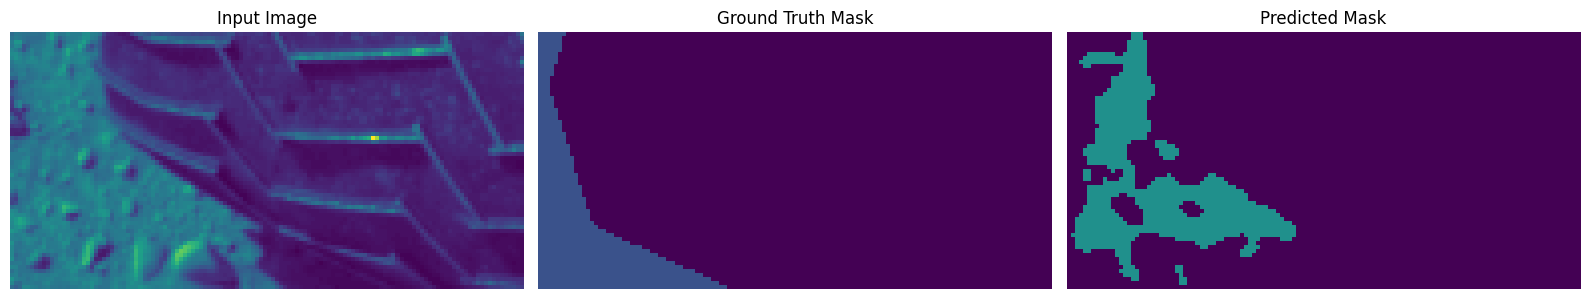

73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.6278 - loss: 0.4941 - mean_iou: 0.3767 - val_accuracy: 0.3701 - val_loss: 0.6665 - val_mean_iou: 0.1104 - learning_rate: 5.0000e-04
Epoch 34/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.6403 - loss: 0.4631 - mean_iou: 0.3888 - val_accuracy: 0.4478 - val_loss: 0.5894 - val_mean_iou: 0.1762 - learning_rate: 5.0000e-04
Epoch 35/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.6437 - loss: 0.4520 - mean_iou: 0.3937 - val_accuracy: 0.5121 - val_loss: 0.5877 - val_mean_iou: 0.2394 - learning_rate: 5.0000e-04
Epoch 36/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.6485 - loss: 0.4444 - mean_iou: 0.3982 - val_accuracy: 0.5687 - val_loss: 0.4980 - val_mean_iou: 0.2568 - learning_rate: 5.0000e-04
Epoch 37/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.6544 - loss: 0.4331 - mean_iou: 0.3978

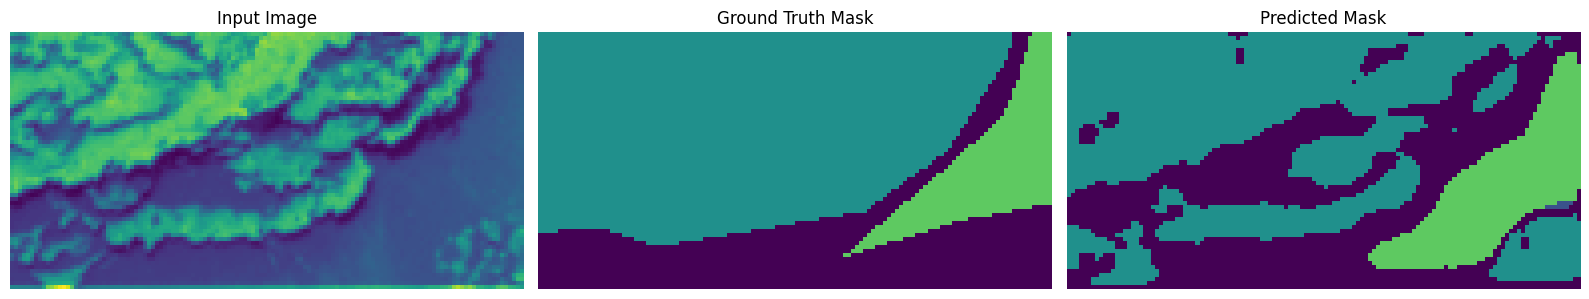

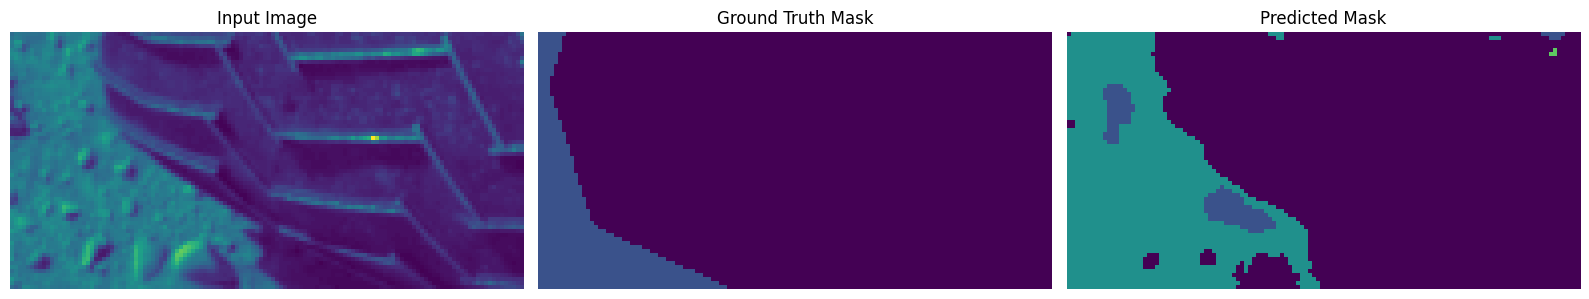

73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.6544 - loss: 0.4332 - mean_iou: 0.3977 - val_accuracy: 0.5250 - val_loss: 0.5919 - val_mean_iou: 0.2731 - learning_rate: 5.0000e-04
Epoch 38/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.6325 - loss: 0.4643 - mean_iou: 0.3801 - val_accuracy: 0.5449 - val_loss: 0.6584 - val_mean_iou: 0.2739 - learning_rate: 5.0000e-04
Epoch 39/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.6400 - loss: 0.4640 - mean_iou: 0.3877 - val_accuracy: 0.4503 - val_loss: 0.5910 - val_mean_iou: 0.2017 - learning_rate: 5.0000e-04
Epoch 40/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.6571 - loss: 0.4296 - mean_iou: 0.4019 - val_accuracy: 0.5712 - val_loss: 0.5030 - val_mean_iou: 0.2337 - learning_rate: 2.5000e-04
Epoch 41/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.6688 - loss: 0.3987 - mean_iou: 0.4099

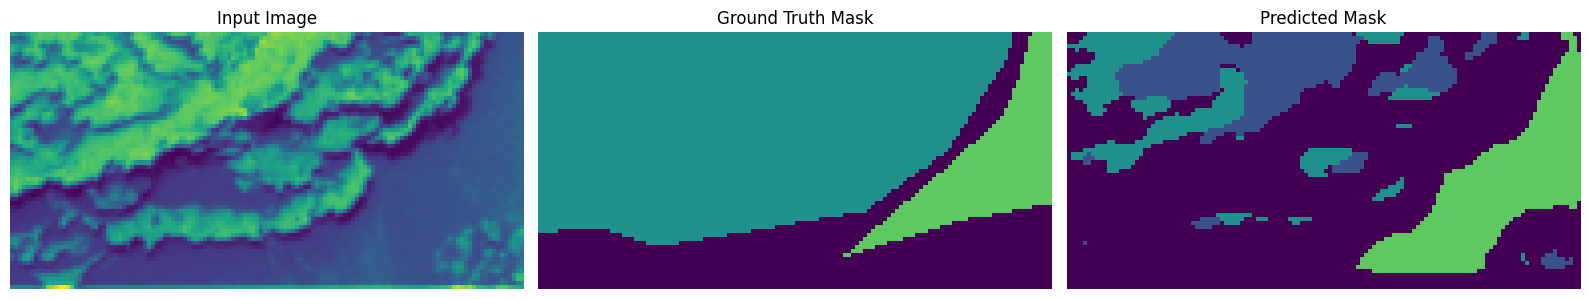

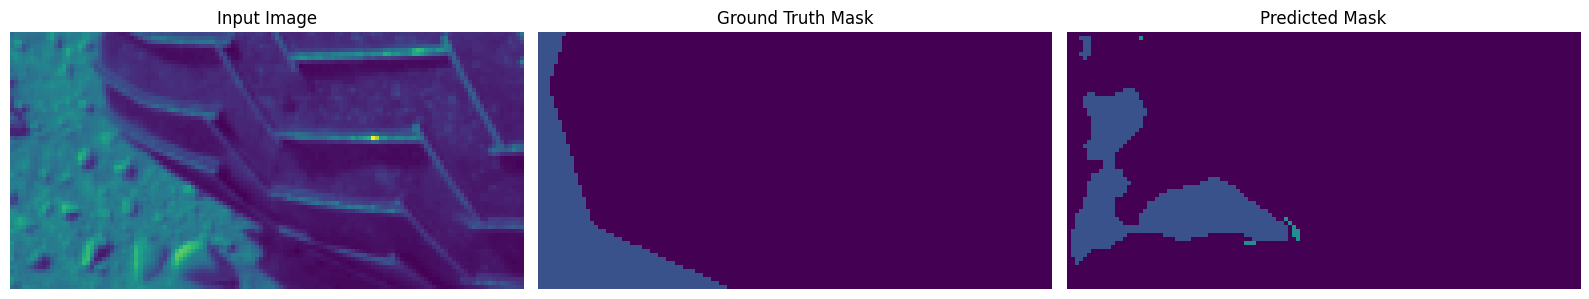

73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.6688 - loss: 0.3989 - mean_iou: 0.4099 - val_accuracy: 0.7091 - val_loss: 0.3967 - val_mean_iou: 0.3895 - learning_rate: 2.5000e-04
Epoch 42/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.6649 - loss: 0.4023 - mean_iou: 0.4026 - val_accuracy: 0.5311 - val_loss: 0.5713 - val_mean_iou: 0.2781 - learning_rate: 2.5000e-04
Epoch 43/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.6746 - loss: 0.3948 - mean_iou: 0.4081 - val_accuracy: 0.6848 - val_loss: 0.4507 - val_mean_iou: 0.4125 - learning_rate: 2.5000e-04
Epoch 44/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.6758 - loss: 0.3880 - mean_iou: 0.4079 - val_accuracy: 0.6883 - val_loss: 0.4209 - val_mean_iou: 0.4175 - learning_rate: 2.5000e-04
Epoch 45/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.6780 - loss: 0.3889 - mean_iou: 0.4108

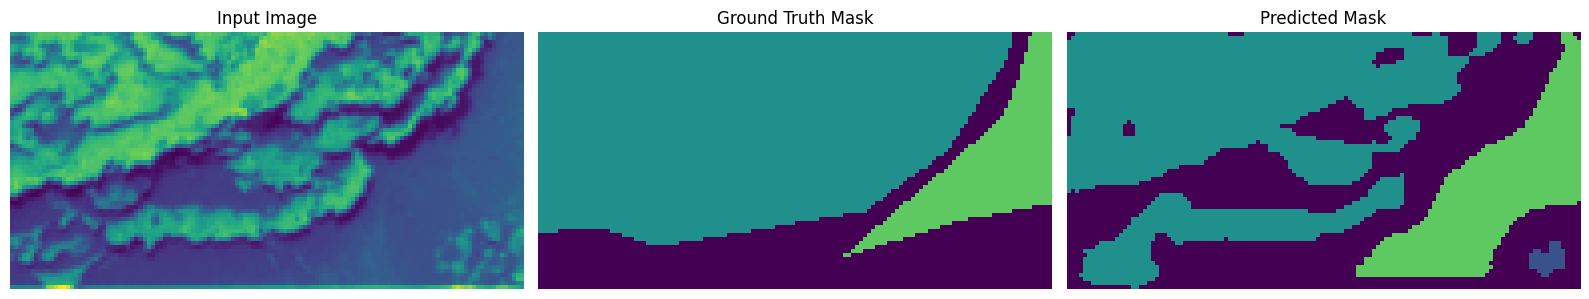

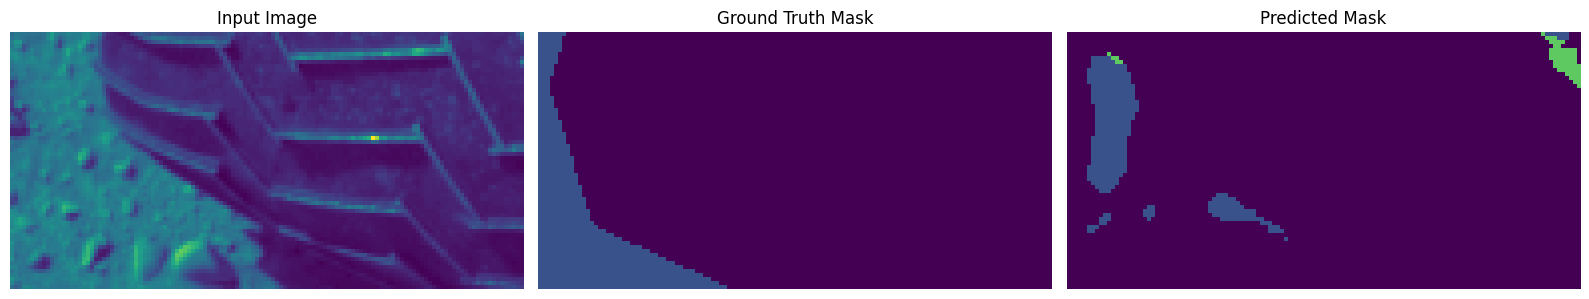

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.6779 - loss: 0.3890 - mean_iou: 0.4107 - val_accuracy: 0.7057 - val_loss: 0.4029 - val_mean_iou: 0.4046 - learning_rate: 2.5000e-04
Epoch 46/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.6768 - loss: 0.3812 - mean_iou: 0.4226 - val_accuracy: 0.7014 - val_loss: 0.4164 - val_mean_iou: 0.3955 - learning_rate: 2.5000e-04
Epoch 47/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.6881 - loss: 0.3732 - mean_iou: 0.4296 - val_accuracy: 0.5496 - val_loss: 0.8392 - val_mean_iou: 0.2520 - learning_rate: 2.5000e-04
Epoch 48/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.6847 - loss: 0.3749 - mean_iou: 0.4283 - val_accuracy: 0.5469 - val_loss: 0.8360 - val_mean_iou: 0.2497 - learning_rate: 2.5000e-04
Epoch 49/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.6732 - loss: 0.3847 - mean_iou: 0.4181

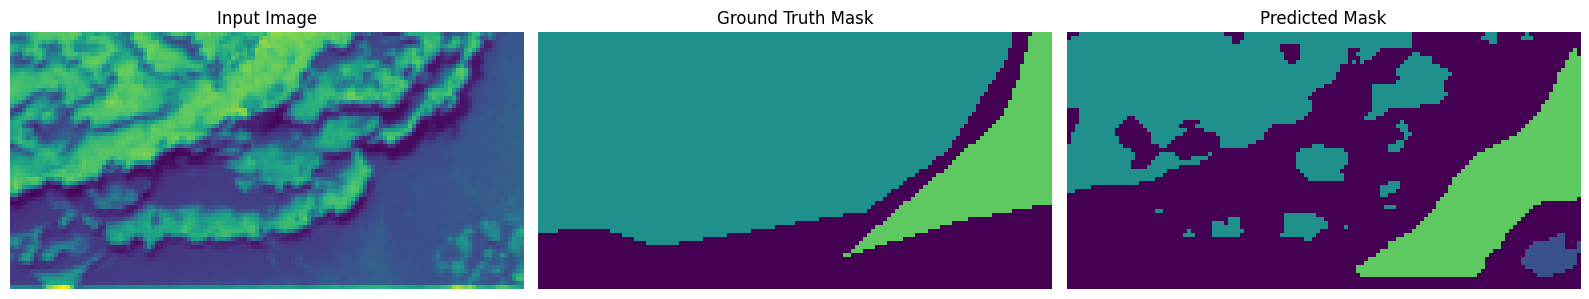

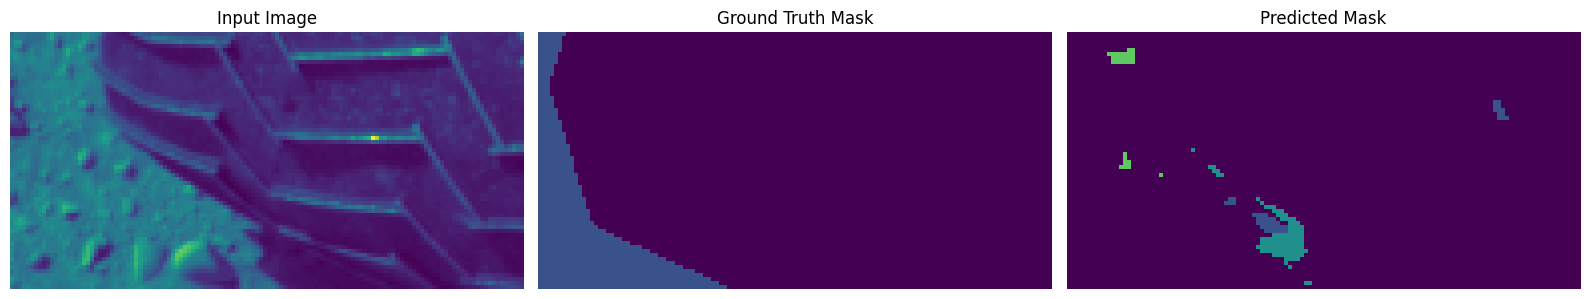

73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.6733 - loss: 0.3847 - mean_iou: 0.4181 - val_accuracy: 0.7365 - val_loss: 0.3529 - val_mean_iou: 0.4297 - learning_rate: 2.5000e-04
Epoch 50/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.6910 - loss: 0.3662 - mean_iou: 0.4311 - val_accuracy: 0.7041 - val_loss: 0.3742 - val_mean_iou: 0.4325 - learning_rate: 2.5000e-04
Epoch 51/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.6841 - loss: 0.3732 - mean_iou: 0.4259 - val_accuracy: 0.6894 - val_loss: 0.3985 - val_mean_iou: 0.3805 - learning_rate: 2.5000e-04
Epoch 52/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.6791 - loss: 0.3751 - mean_iou: 0.4202 - val_accuracy: 0.6798 - val_loss: 0.3978 - val_mean_iou: 0.3722 - learning_rate: 2.5000e-04
Epoch 53/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.6881 - loss: 0.3697 - mean_iou: 0.4288

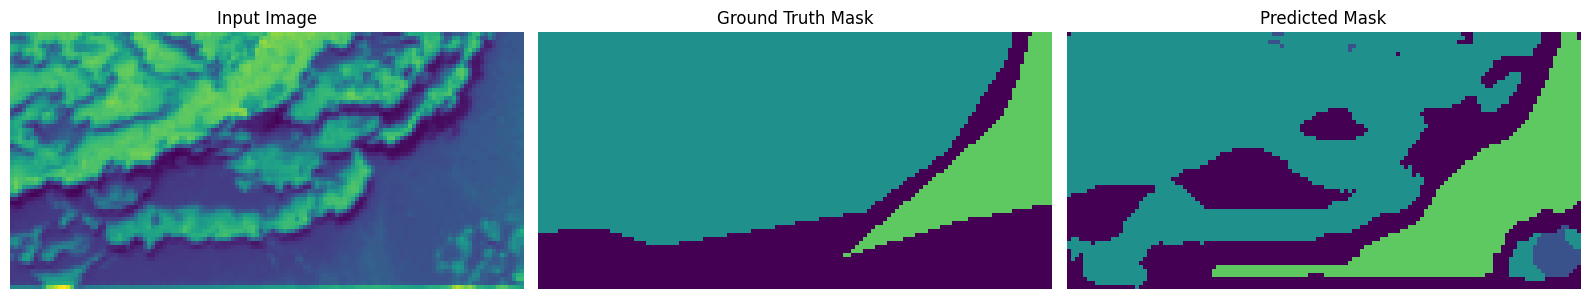

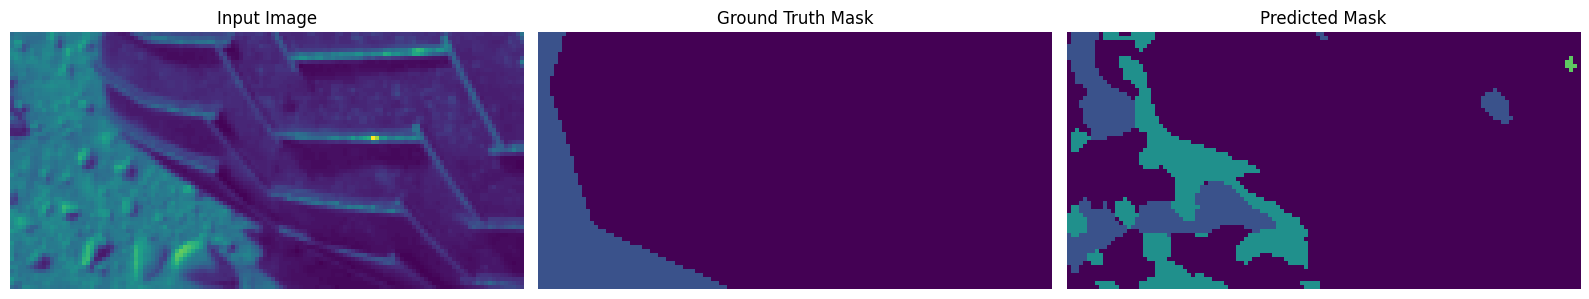

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.6881 - loss: 0.3698 - mean_iou: 0.4287 - val_accuracy: 0.6442 - val_loss: 0.4735 - val_mean_iou: 0.3614 - learning_rate: 2.5000e-04
Epoch 54/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.6890 - loss: 0.3662 - mean_iou: 0.4208 - val_accuracy: 0.6597 - val_loss: 0.4038 - val_mean_iou: 0.3699 - learning_rate: 2.5000e-04
Epoch 55/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.6895 - loss: 0.3597 - mean_iou: 0.4280 - val_accuracy: 0.7229 - val_loss: 0.4654 - val_mean_iou: 0.4249 - learning_rate: 2.5000e-04
Epoch 56/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.6806 - loss: 0.3769 - mean_iou: 0.4157 - val_accuracy: 0.4637 - val_loss: 0.5838 - val_mean_iou: 0.2215 - learning_rate: 2.5000e-04
Epoch 57/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.6885 - loss: 0.3775 - mean_iou: 0.4240

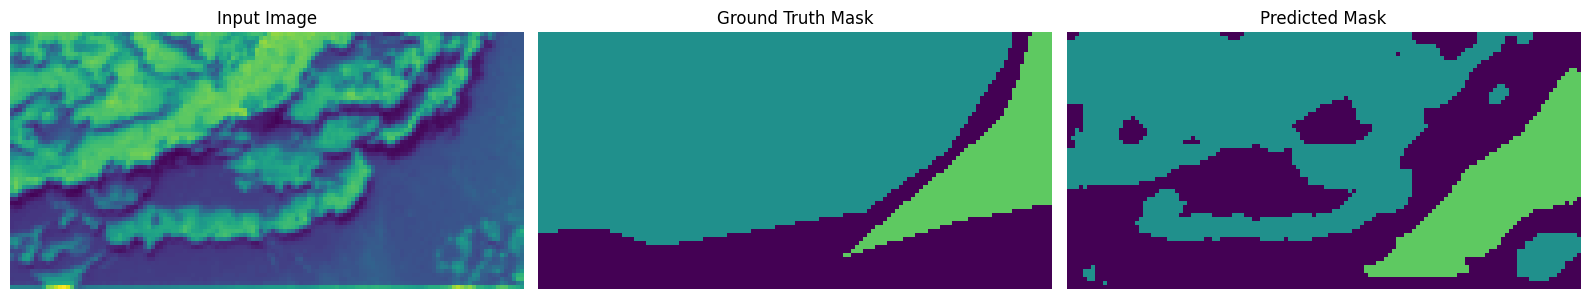

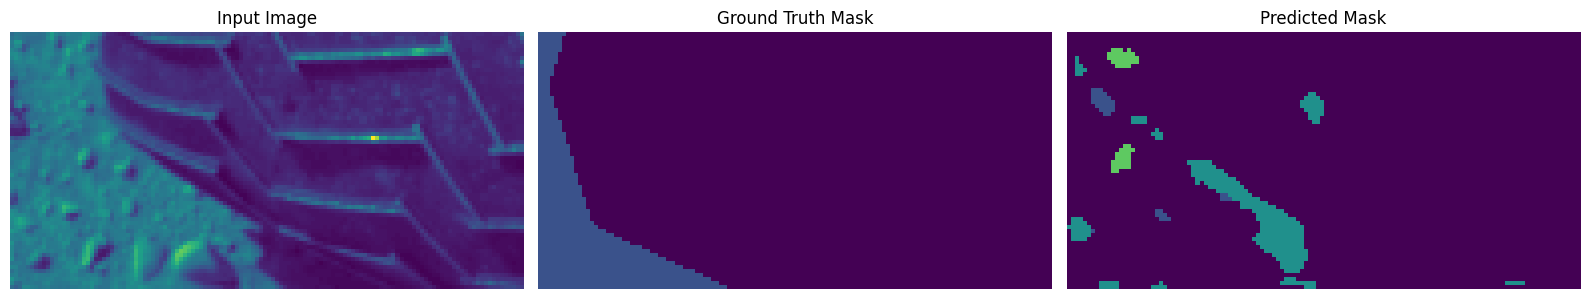

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.6886 - loss: 0.3774 - mean_iou: 0.4240 - val_accuracy: 0.6673 - val_loss: 0.3948 - val_mean_iou: 0.3662 - learning_rate: 2.5000e-04
Epoch 58/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.6857 - loss: 0.3720 - mean_iou: 0.4209 - val_accuracy: 0.4876 - val_loss: 0.5135 - val_mean_iou: 0.2173 - learning_rate: 2.5000e-04
Epoch 59/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.6969 - loss: 0.3664 - mean_iou: 0.4343 - val_accuracy: 0.6711 - val_loss: 0.4846 - val_mean_iou: 0.3519 - learning_rate: 2.5000e-04
Epoch 60/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.6838 - loss: 0.3676 - mean_iou: 0.4193 - val_accuracy: 0.6826 - val_loss: 0.3822 - val_mean_iou: 0.3750 - learning_rate: 2.5000e-04
Epoch 61/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.6922 - loss: 0.3560 - mean_iou: 0.4325

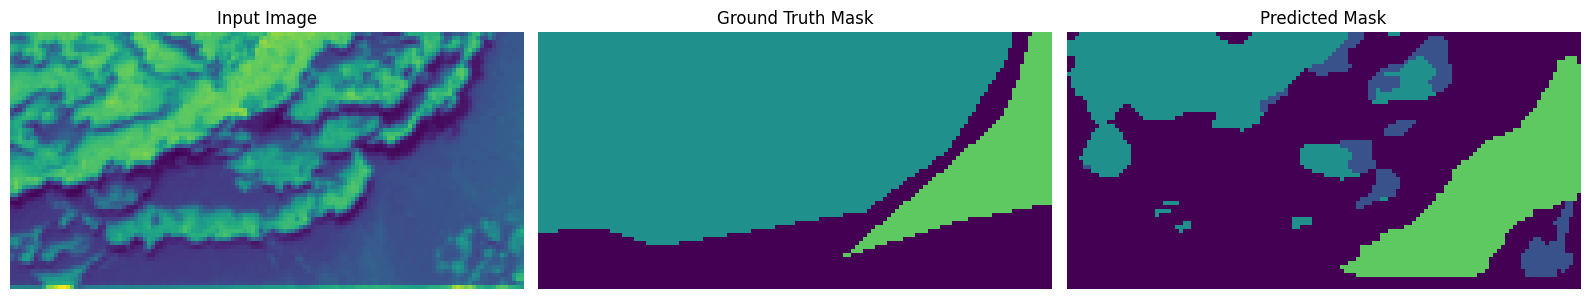

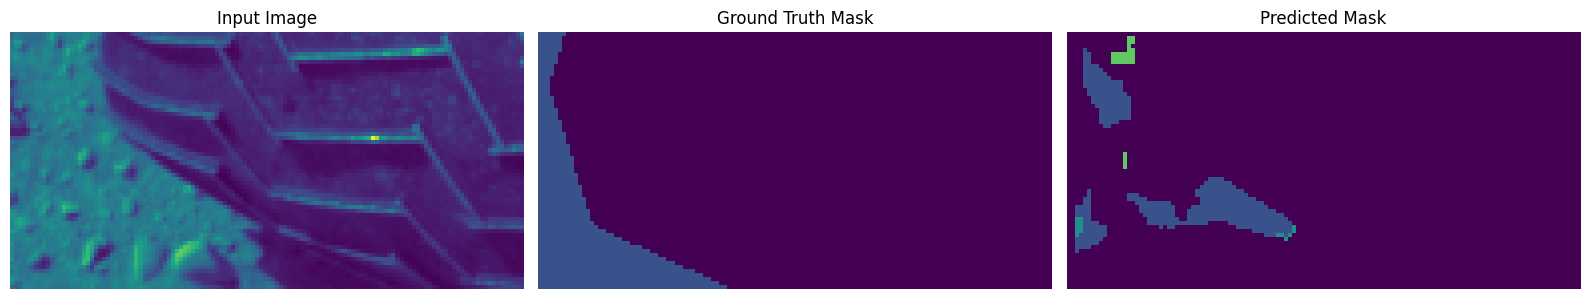

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.6922 - loss: 0.3561 - mean_iou: 0.4324 - val_accuracy: 0.6901 - val_loss: 0.3953 - val_mean_iou: 0.3847 - learning_rate: 2.5000e-04
Epoch 62/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.6959 - loss: 0.3546 - mean_iou: 0.4312 - val_accuracy: 0.6586 - val_loss: 0.3890 - val_mean_iou: 0.3748 - learning_rate: 2.5000e-04
Epoch 63/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.7017 - loss: 0.3448 - mean_iou: 0.4398 - val_accuracy: 0.6301 - val_loss: 0.3871 - val_mean_iou: 0.3447 - learning_rate: 1.2500e-04
Epoch 64/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.7069 - loss: 0.3368 - mean_iou: 0.4425 - val_accuracy: 0.7037 - val_loss: 0.3642 - val_mean_iou: 0.3967 - learning_rate: 1.2500e-04
Epoch 65/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7125 - loss: 0.3264 - mean_iou: 0.4424

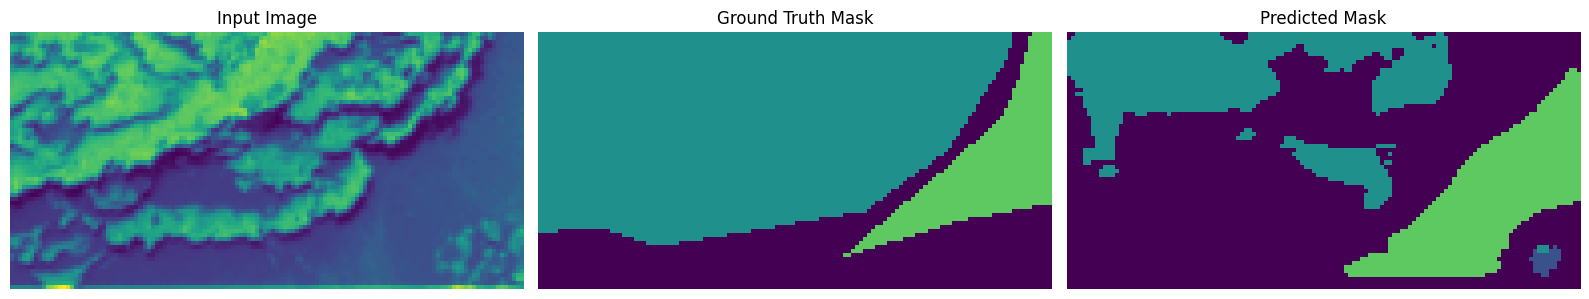

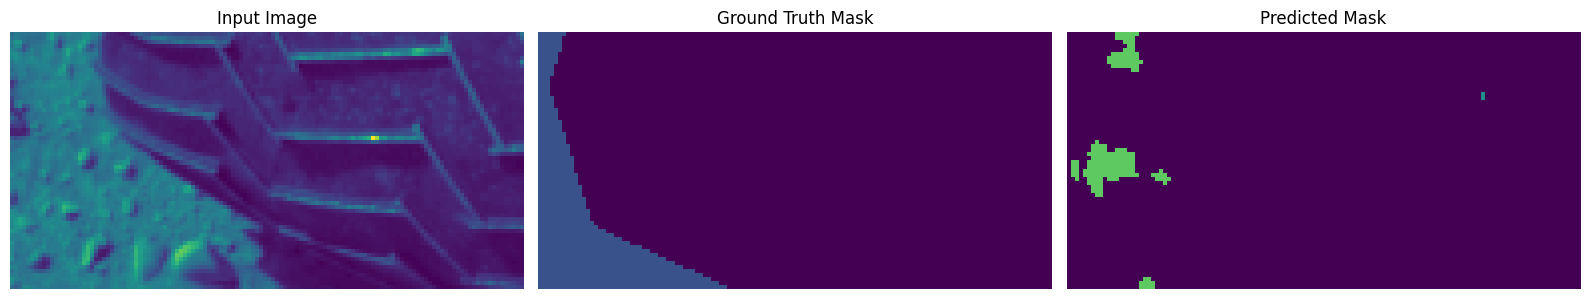

73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.7125 - loss: 0.3264 - mean_iou: 0.4424 - val_accuracy: 0.7022 - val_loss: 0.3586 - val_mean_iou: 0.3973 - learning_rate: 1.2500e-04
Epoch 66/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.7156 - loss: 0.3205 - mean_iou: 0.4532 - val_accuracy: 0.7212 - val_loss: 0.3517 - val_mean_iou: 0.4164 - learning_rate: 1.2500e-04
Epoch 67/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.7126 - loss: 0.3239 - mean_iou: 0.4429 - val_accuracy: 0.6460 - val_loss: 0.3804 - val_mean_iou: 0.3474 - learning_rate: 1.2500e-04
Epoch 68/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.7188 - loss: 0.3176 - mean_iou: 0.4484 - val_accuracy: 0.6839 - val_loss: 0.3465 - val_mean_iou: 0.3968 - learning_rate: 1.2500e-04
Epoch 69/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7176 - loss: 0.3223 - mean_iou: 0.4514

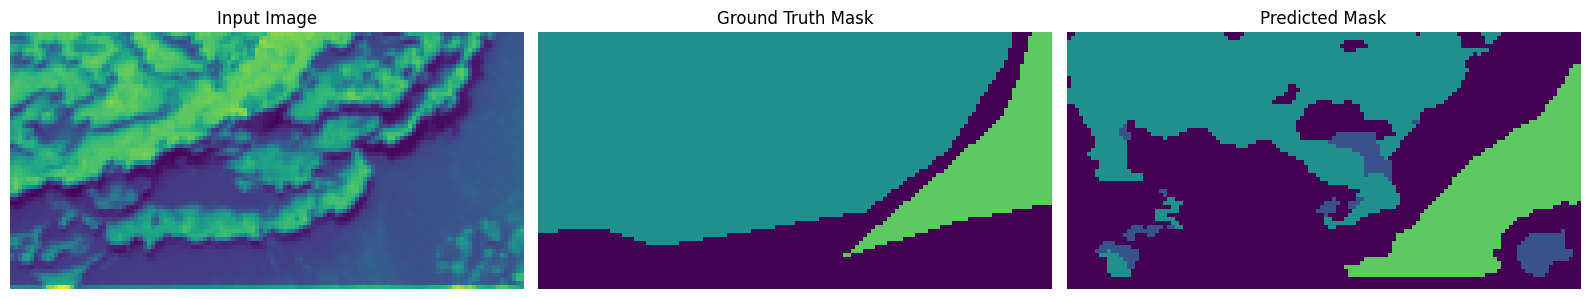

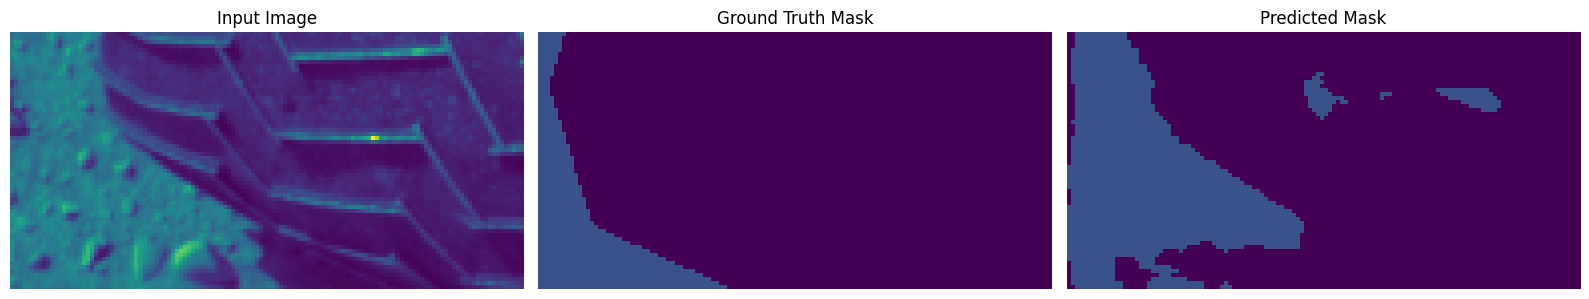

73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.7175 - loss: 0.3224 - mean_iou: 0.4513 - val_accuracy: 0.7319 - val_loss: 0.3647 - val_mean_iou: 0.4184 - learning_rate: 1.2500e-04
Epoch 70/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.7174 - loss: 0.3186 - mean_iou: 0.4569 - val_accuracy: 0.6841 - val_loss: 0.3932 - val_mean_iou: 0.3893 - learning_rate: 1.2500e-04
Epoch 71/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.7135 - loss: 0.3234 - mean_iou: 0.4455 - val_accuracy: 0.6900 - val_loss: 0.3594 - val_mean_iou: 0.3970 - learning_rate: 1.2500e-04
Epoch 72/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.7171 - loss: 0.3167 - mean_iou: 0.4569 - val_accuracy: 0.7229 - val_loss: 0.3349 - val_mean_iou: 0.4248 - learning_rate: 1.2500e-04
Epoch 73/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7208 - loss: 0.3175 - mean_iou: 0.4578

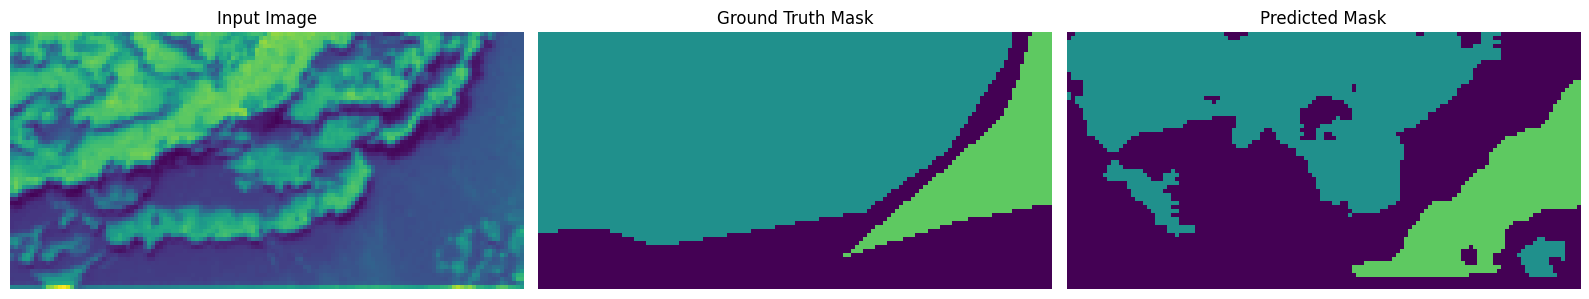

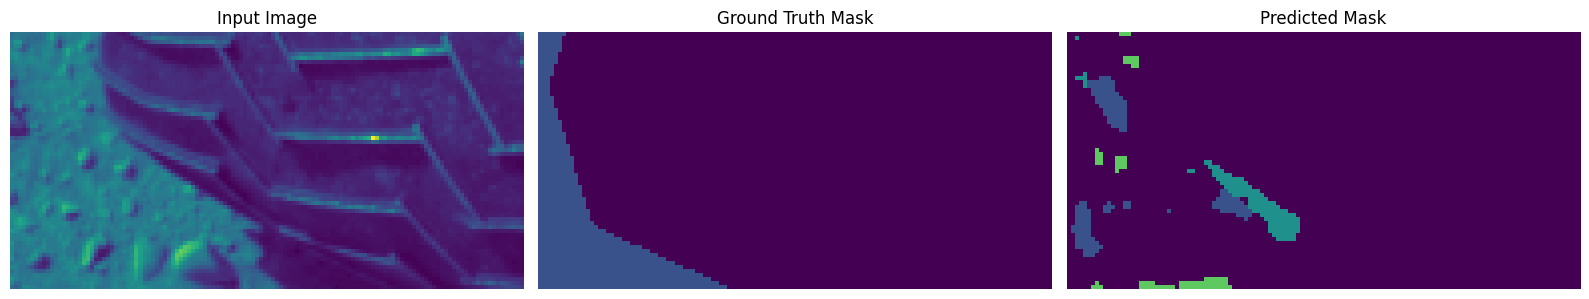

73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.7207 - loss: 0.3176 - mean_iou: 0.4577 - val_accuracy: 0.7329 - val_loss: 0.3445 - val_mean_iou: 0.4248 - learning_rate: 1.2500e-04
Epoch 74/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.7191 - loss: 0.3164 - mean_iou: 0.4544 - val_accuracy: 0.7731 - val_loss: 0.3045 - val_mean_iou: 0.4709 - learning_rate: 1.2500e-04
Epoch 75/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.7200 - loss: 0.3135 - mean_iou: 0.4522 - val_accuracy: 0.6683 - val_loss: 0.3840 - val_mean_iou: 0.3890 - learning_rate: 1.2500e-04
Epoch 76/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.7180 - loss: 0.3145 - mean_iou: 0.4519 - val_accuracy: 0.7010 - val_loss: 0.3629 - val_mean_iou: 0.4049 - learning_rate: 1.2500e-04
Epoch 77/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7179 - loss: 0.3146 - mean_iou: 0.4516

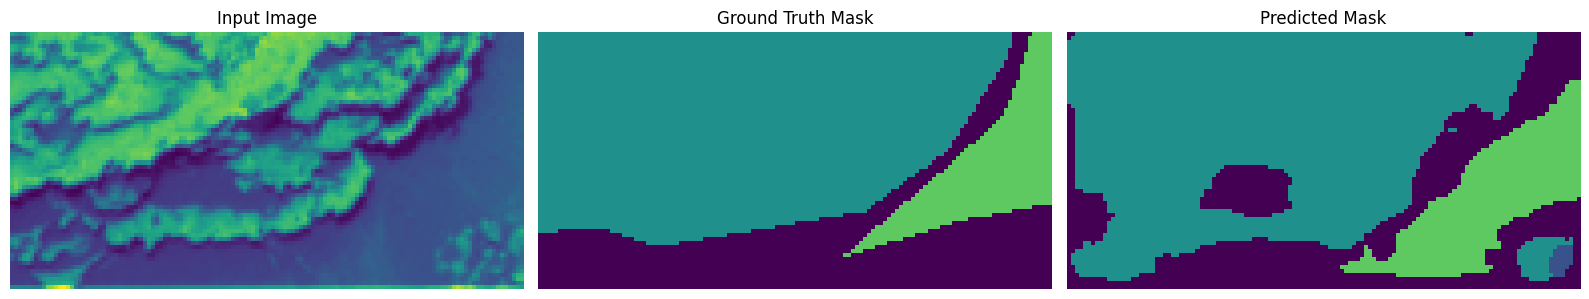

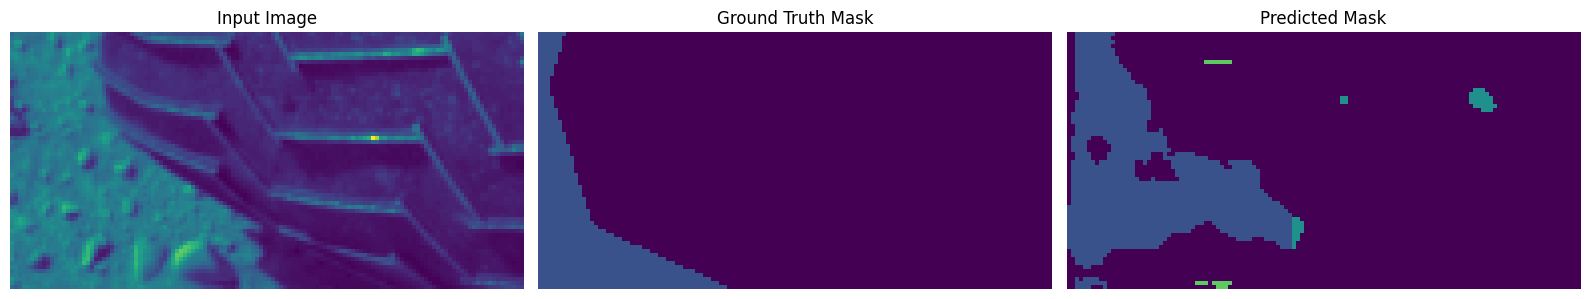

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - accuracy: 0.7178 - loss: 0.3147 - mean_iou: 0.4516 - val_accuracy: 0.7637 - val_loss: 0.3299 - val_mean_iou: 0.4762 - learning_rate: 1.2500e-04
Epoch 78/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.7193 - loss: 0.3163 - mean_iou: 0.4541 - val_accuracy: 0.6983 - val_loss: 0.3708 - val_mean_iou: 0.4080 - learning_rate: 1.2500e-04
Epoch 79/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.7209 - loss: 0.3099 - mean_iou: 0.4551 - val_accuracy: 0.7514 - val_loss: 0.3280 - val_mean_iou: 0.4614 - learning_rate: 1.2500e-04
Epoch 80/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.7212 - loss: 0.3123 - mean_iou: 0.4576 - val_accuracy: 0.7050 - val_loss: 0.3905 - val_mean_iou: 0.3880 - learning_rate: 1.2500e-04
Epoch 81/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7230 - loss: 0.3107 - mean_iou: 0.4574

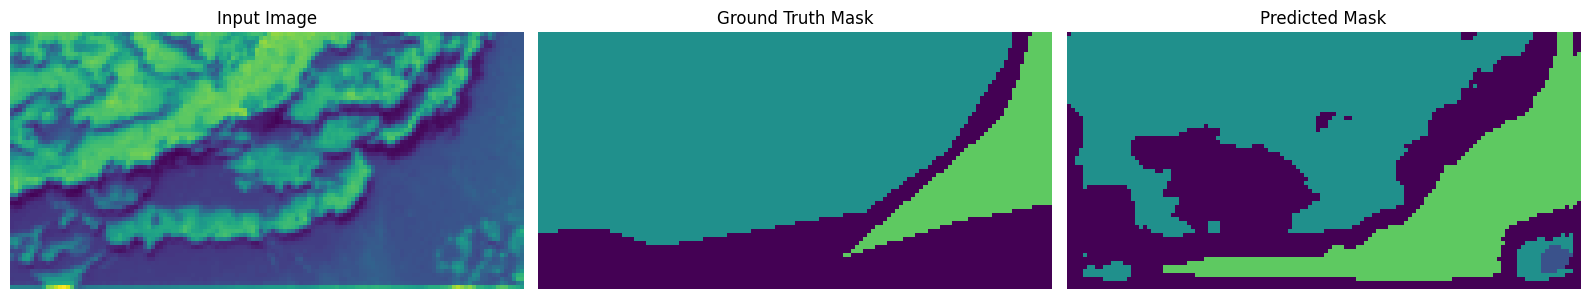

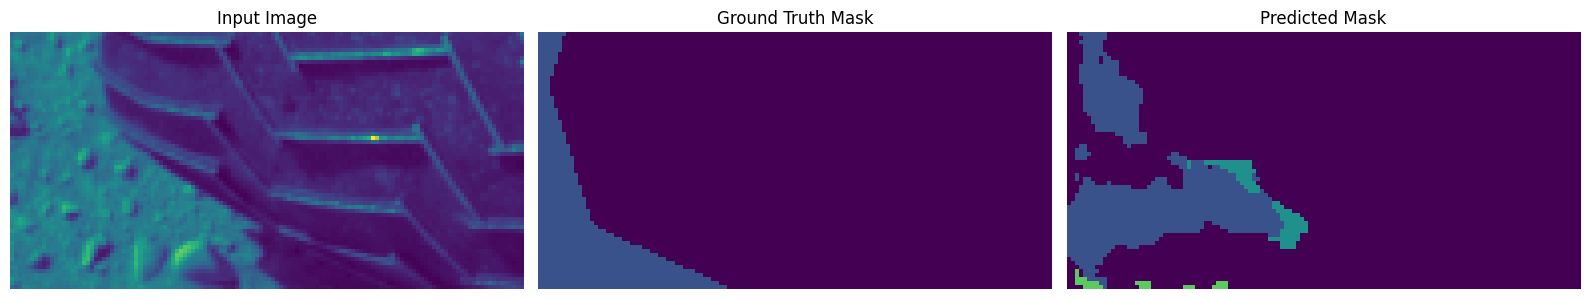

73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.7229 - loss: 0.3107 - mean_iou: 0.4575 - val_accuracy: 0.7245 - val_loss: 0.3621 - val_mean_iou: 0.4323 - learning_rate: 1.2500e-04
Epoch 82/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.7296 - loss: 0.3037 - mean_iou: 0.4644 - val_accuracy: 0.7599 - val_loss: 0.3291 - val_mean_iou: 0.4533 - learning_rate: 1.2500e-04
Epoch 83/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.7295 - loss: 0.3027 - mean_iou: 0.4678 - val_accuracy: 0.6932 - val_loss: 0.3655 - val_mean_iou: 0.4036 - learning_rate: 1.2500e-04
Epoch 84/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.7291 - loss: 0.3019 - mean_iou: 0.4659 - val_accuracy: 0.7319 - val_loss: 0.3532 - val_mean_iou: 0.4092 - learning_rate: 1.2500e-04
Epoch 85/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7319 - loss: 0.3008 - mean_iou: 0.4744

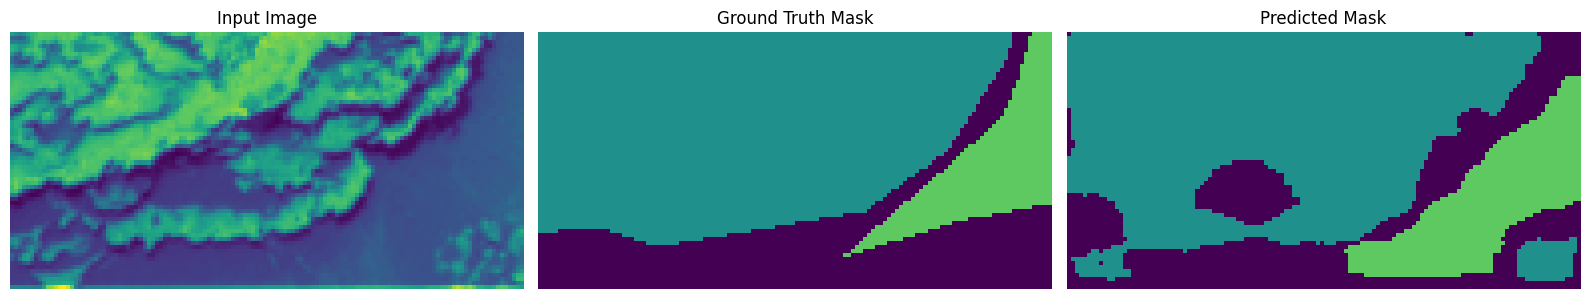

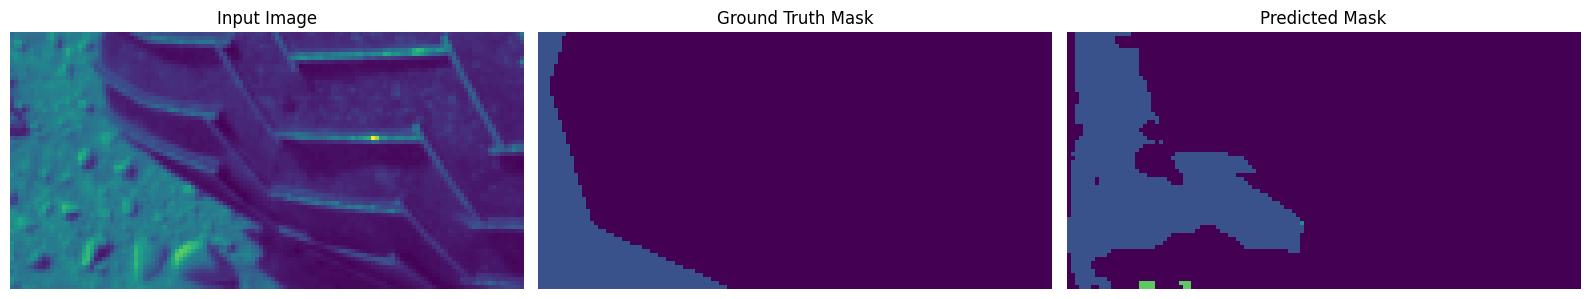

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.7318 - loss: 0.3009 - mean_iou: 0.4744 - val_accuracy: 0.7550 - val_loss: 0.3339 - val_mean_iou: 0.4674 - learning_rate: 1.2500e-04
Epoch 86/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.7202 - loss: 0.3176 - mean_iou: 0.4532 - val_accuracy: 0.7149 - val_loss: 0.3502 - val_mean_iou: 0.4309 - learning_rate: 1.2500e-04
Epoch 87/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.7308 - loss: 0.3041 - mean_iou: 0.4644 - val_accuracy: 0.7465 - val_loss: 0.3411 - val_mean_iou: 0.4531 - learning_rate: 1.2500e-04
Epoch 88/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.7343 - loss: 0.2984 - mean_iou: 0.4747 - val_accuracy: 0.6734 - val_loss: 0.4693 - val_mean_iou: 0.3813 - learning_rate: 1.2500e-04
Epoch 89/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7316 - loss: 0.2994 - mean_iou: 0.4733

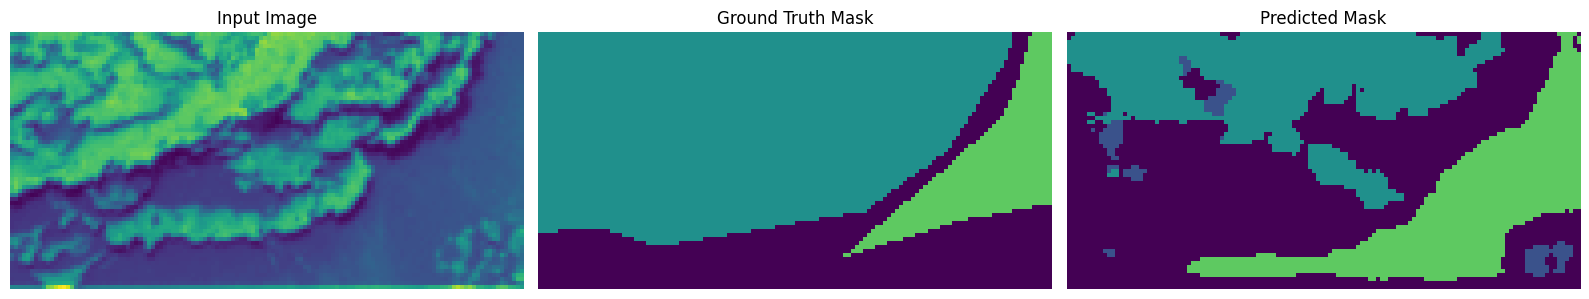

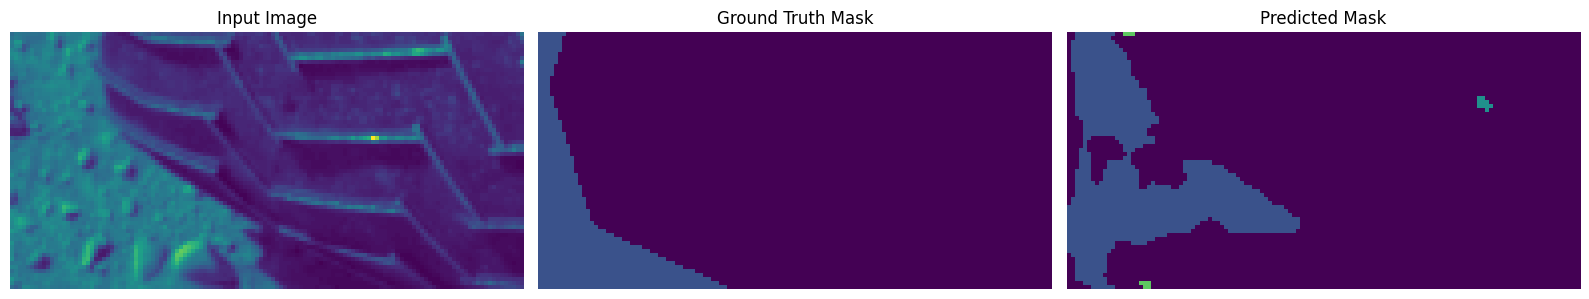

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.7316 - loss: 0.2995 - mean_iou: 0.4733 - val_accuracy: 0.6870 - val_loss: 0.4040 - val_mean_iou: 0.3821 - learning_rate: 1.2500e-04
Epoch 90/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.7437 - loss: 0.2911 - mean_iou: 0.4820 - val_accuracy: 0.7653 - val_loss: 0.3042 - val_mean_iou: 0.4596 - learning_rate: 6.2500e-05
Epoch 91/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.7584 - loss: 0.2751 - mean_iou: 0.4974 - val_accuracy: 0.7200 - val_loss: 0.3792 - val_mean_iou: 0.4090 - learning_rate: 6.2500e-05
Epoch 92/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.7604 - loss: 0.2709 - mean_iou: 0.5034 - val_accuracy: 0.7351 - val_loss: 0.3477 - val_mean_iou: 0.4252 - learning_rate: 6.2500e-05
Epoch 93/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7629 - loss: 0.2676 - mean_iou: 0.5091

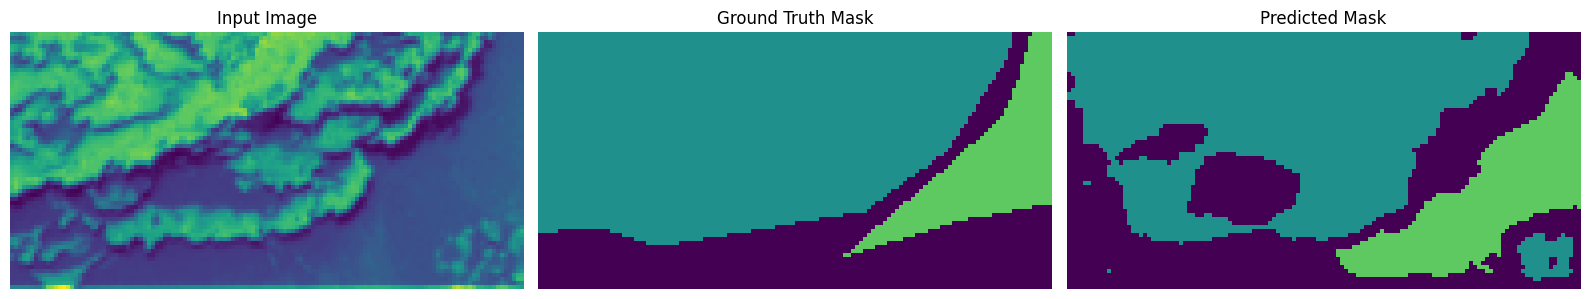

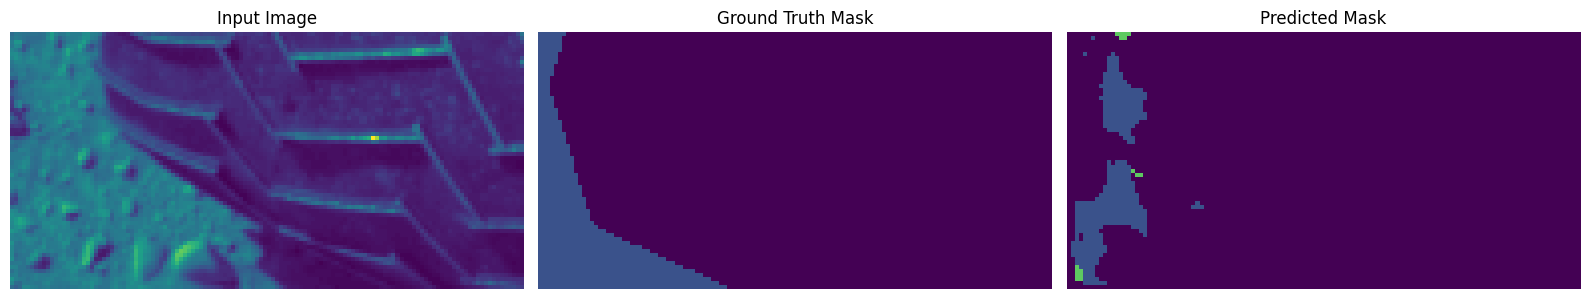

73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.7628 - loss: 0.2677 - mean_iou: 0.5091 - val_accuracy: 0.7499 - val_loss: 0.3144 - val_mean_iou: 0.4440 - learning_rate: 6.2500e-05
Epoch 94/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.7633 - loss: 0.2646 - mean_iou: 0.5085 - val_accuracy: 0.7441 - val_loss: 0.3474 - val_mean_iou: 0.4266 - learning_rate: 6.2500e-05
Epoch 95/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.7654 - loss: 0.2623 - mean_iou: 0.5109 - val_accuracy: 0.7707 - val_loss: 0.3268 - val_mean_iou: 0.4547 - learning_rate: 6.2500e-05
Epoch 96/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.7575 - loss: 0.2671 - mean_iou: 0.5016 - val_accuracy: 0.7588 - val_loss: 0.2979 - val_mean_iou: 0.4620 - learning_rate: 6.2500e-05
Epoch 97/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7714 - loss: 0.2557 - mean_iou: 0.5200

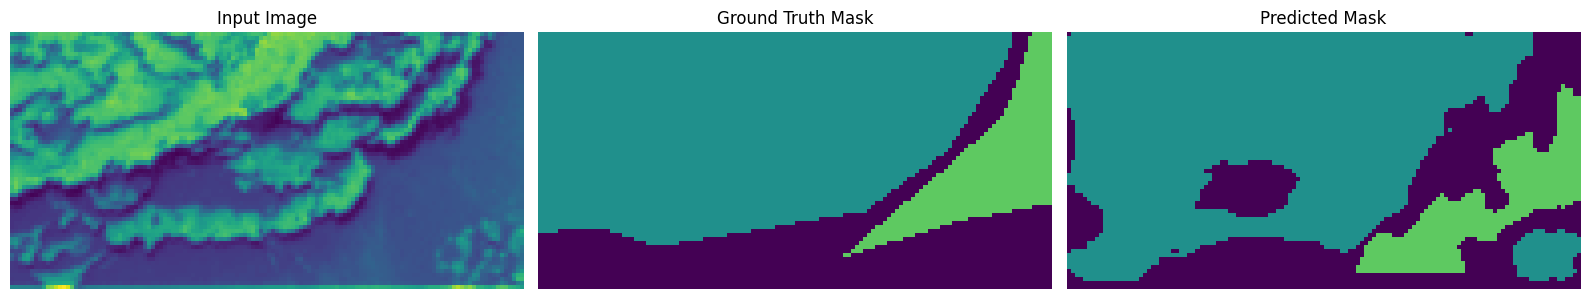

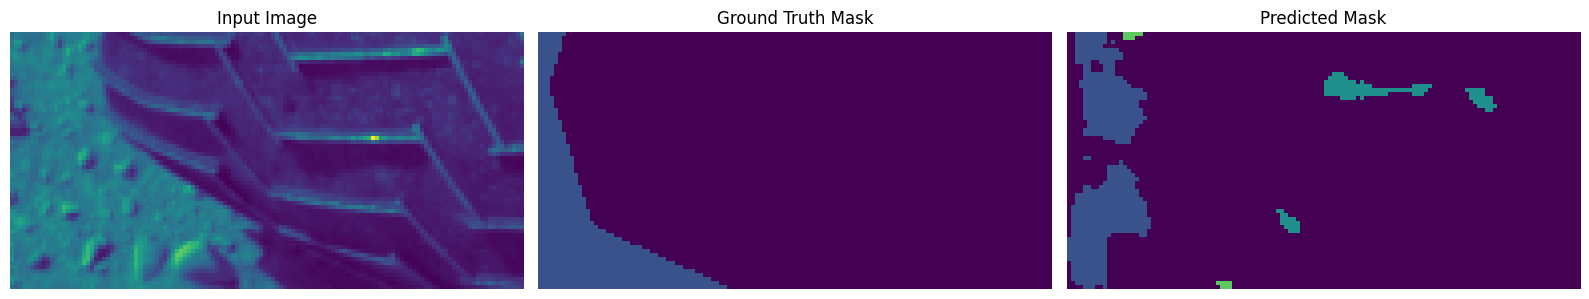

73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.7712 - loss: 0.2558 - mean_iou: 0.5200 - val_accuracy: 0.7640 - val_loss: 0.3078 - val_mean_iou: 0.4551 - learning_rate: 6.2500e-05
Epoch 98/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.7661 - loss: 0.2609 - mean_iou: 0.5065 - val_accuracy: 0.7613 - val_loss: 0.3816 - val_mean_iou: 0.4721 - learning_rate: 6.2500e-05
Epoch 99/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.7711 - loss: 0.2571 - mean_iou: 0.5166 - val_accuracy: 0.7552 - val_loss: 0.3272 - val_mean_iou: 0.4447 - learning_rate: 6.2500e-05
Epoch 100/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.7764 - loss: 0.2502 - mean_iou: 0.5248 - val_accuracy: 0.7424 - val_loss: 0.3606 - val_mean_iou: 0.4260 - learning_rate: 6.2500e-05
Epoch 101/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7766 - loss: 0.2475 - mean_iou: 0.5295

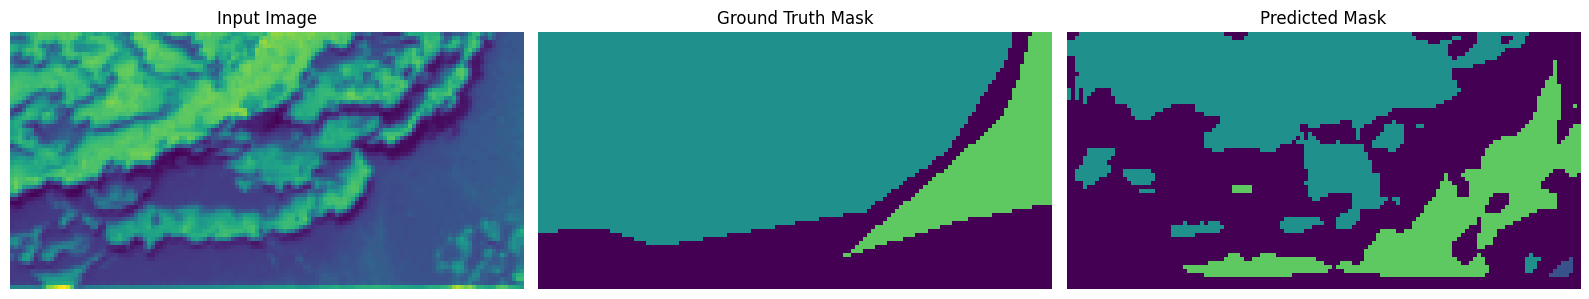

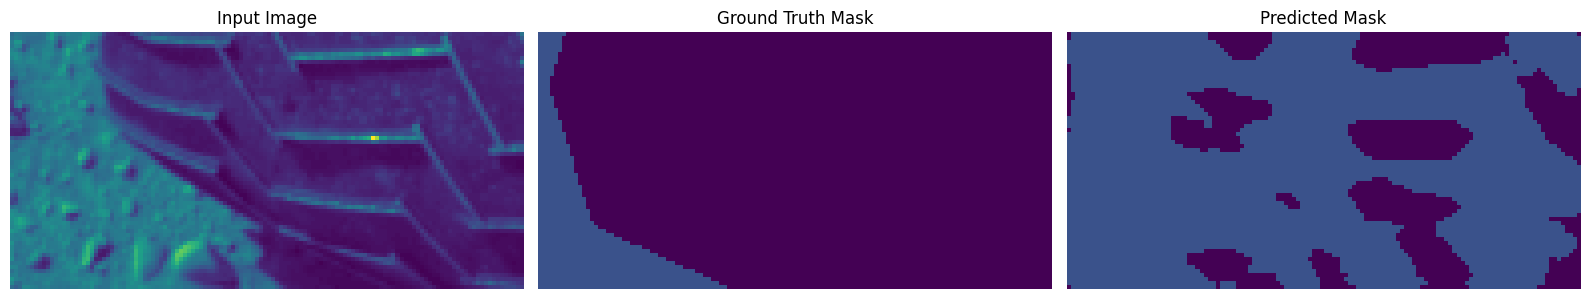

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.7764 - loss: 0.2477 - mean_iou: 0.5294 - val_accuracy: 0.6291 - val_loss: 0.6982 - val_mean_iou: 0.3374 - learning_rate: 6.2500e-05
Epoch 102/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.7647 - loss: 0.2619 - mean_iou: 0.5094 - val_accuracy: 0.7616 - val_loss: 0.2960 - val_mean_iou: 0.4779 - learning_rate: 3.1250e-05
Epoch 103/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.7802 - loss: 0.2444 - mean_iou: 0.5292 - val_accuracy: 0.7665 - val_loss: 0.2885 - val_mean_iou: 0.4774 - learning_rate: 3.1250e-05
Epoch 104/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.7866 - loss: 0.2344 - mean_iou: 0.5436 - val_accuracy: 0.7606 - val_loss: 0.3034 - val_mean_iou: 0.4630 - learning_rate: 3.1250e-05
Epoch 105/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7923 - loss: 0.2272 - mean_iou: 0.5492

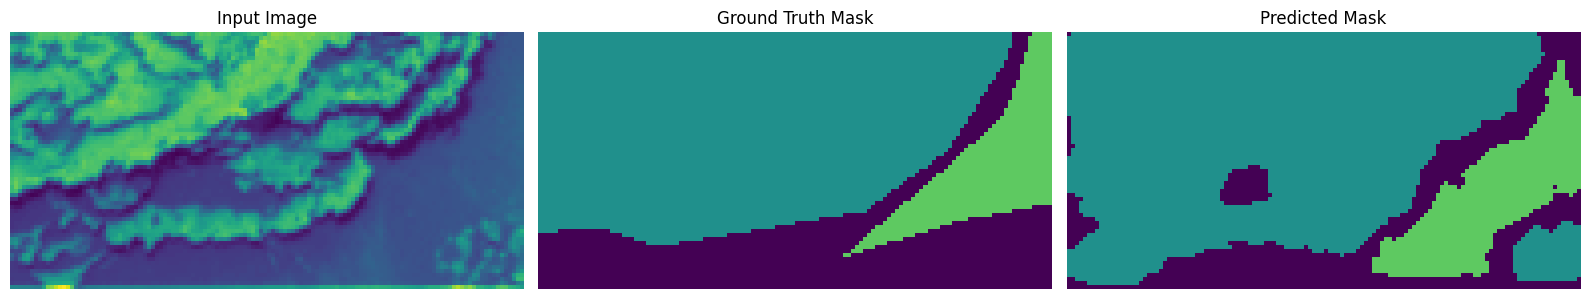

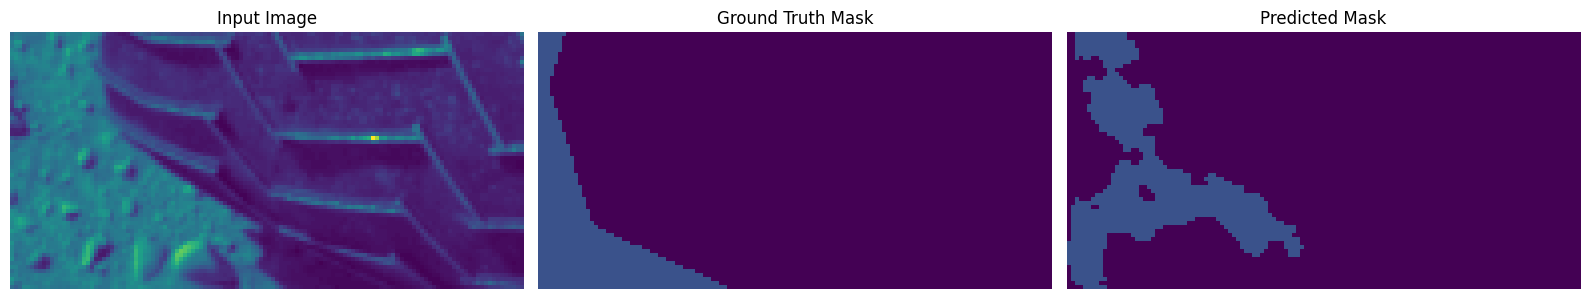

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - accuracy: 0.7921 - loss: 0.2273 - mean_iou: 0.5493 - val_accuracy: 0.7700 - val_loss: 0.2839 - val_mean_iou: 0.4814 - learning_rate: 3.1250e-05
Epoch 106/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.7920 - loss: 0.2264 - mean_iou: 0.5524 - val_accuracy: 0.7698 - val_loss: 0.2863 - val_mean_iou: 0.4774 - learning_rate: 3.1250e-05
Epoch 107/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.7917 - loss: 0.2260 - mean_iou: 0.5519 - val_accuracy: 0.7763 - val_loss: 0.2795 - val_mean_iou: 0.4776 - learning_rate: 3.1250e-05
Epoch 108/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.7933 - loss: 0.2249 - mean_iou: 0.5531 - val_accuracy: 0.7682 - val_loss: 0.2889 - val_mean_iou: 0.4803 - learning_rate: 3.1250e-05
Epoch 109/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7960 - loss: 0.2226 - mean_iou: 0.5548

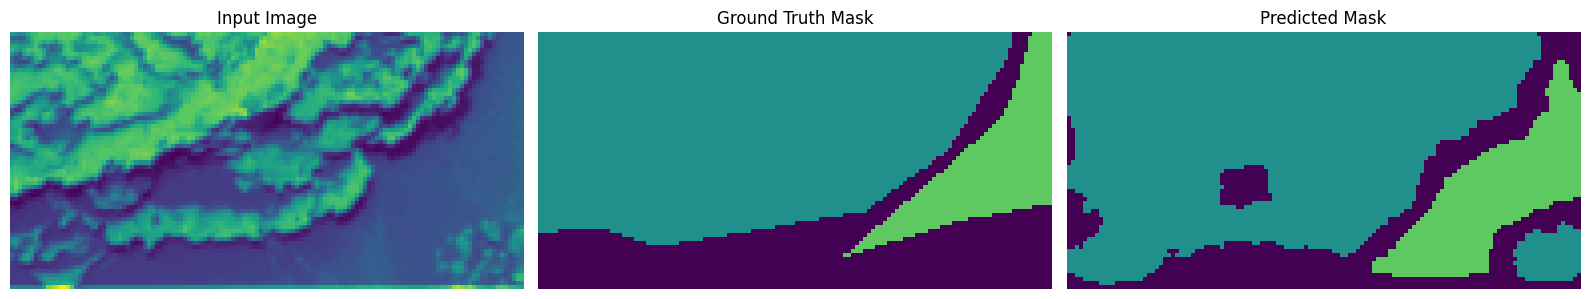

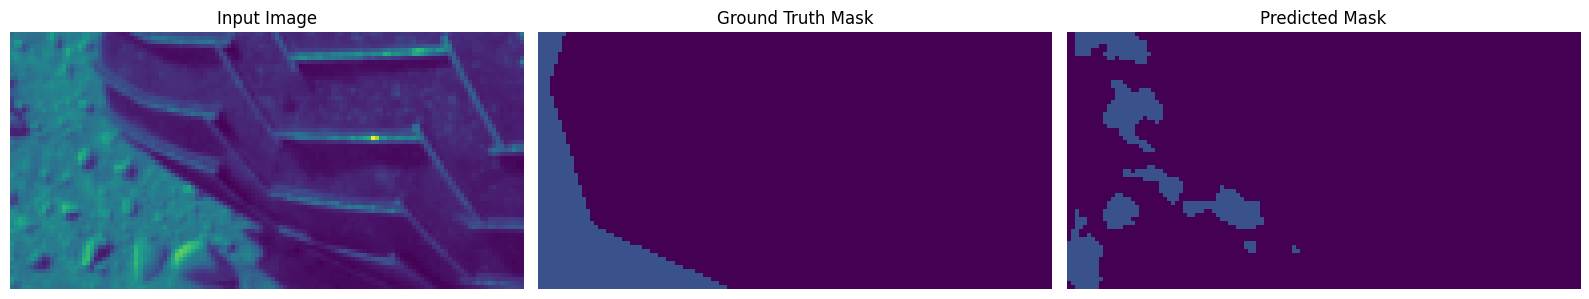

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - accuracy: 0.7959 - loss: 0.2226 - mean_iou: 0.5549 - val_accuracy: 0.7760 - val_loss: 0.2770 - val_mean_iou: 0.4981 - learning_rate: 3.1250e-05
Epoch 110/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.8000 - loss: 0.2159 - mean_iou: 0.5638 - val_accuracy: 0.7754 - val_loss: 0.2818 - val_mean_iou: 0.4929 - learning_rate: 3.1250e-05
Epoch 111/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.8034 - loss: 0.2106 - mean_iou: 0.5715 - val_accuracy: 0.7547 - val_loss: 0.3002 - val_mean_iou: 0.4615 - learning_rate: 3.1250e-05
Epoch 112/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.7999 - loss: 0.2128 - mean_iou: 0.5639 - val_accuracy: 0.7524 - val_loss: 0.2991 - val_mean_iou: 0.4840 - learning_rate: 3.1250e-05
Epoch 113/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8002 - loss: 0.2153 - mean_iou: 0.5563

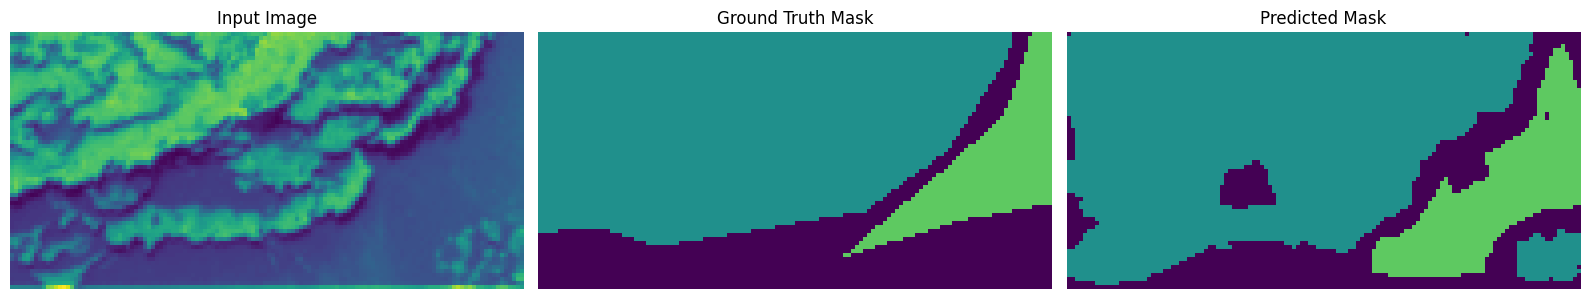

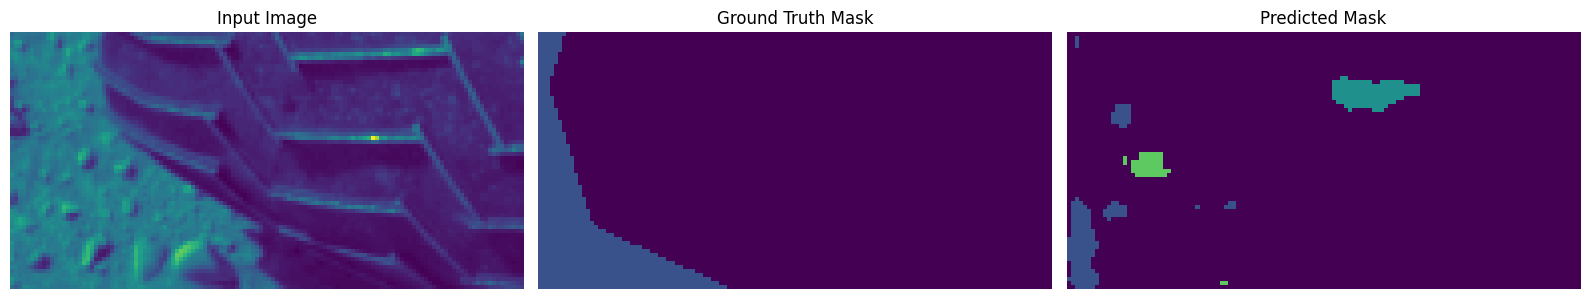

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.8000 - loss: 0.2155 - mean_iou: 0.5563 - val_accuracy: 0.7779 - val_loss: 0.2727 - val_mean_iou: 0.4951 - learning_rate: 3.1250e-05
Epoch 114/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.8033 - loss: 0.2124 - mean_iou: 0.5630 - val_accuracy: 0.7661 - val_loss: 0.2840 - val_mean_iou: 0.4773 - learning_rate: 3.1250e-05
Epoch 115/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.8090 - loss: 0.2035 - mean_iou: 0.5723 - val_accuracy: 0.7444 - val_loss: 0.3052 - val_mean_iou: 0.4575 - learning_rate: 3.1250e-05
Epoch 116/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.8116 - loss: 0.2026 - mean_iou: 0.5696 - val_accuracy: 0.7639 - val_loss: 0.2977 - val_mean_iou: 0.4656 - learning_rate: 3.1250e-05
Epoch 117/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8119 - loss: 0.1995 - mean_iou: 0.5758

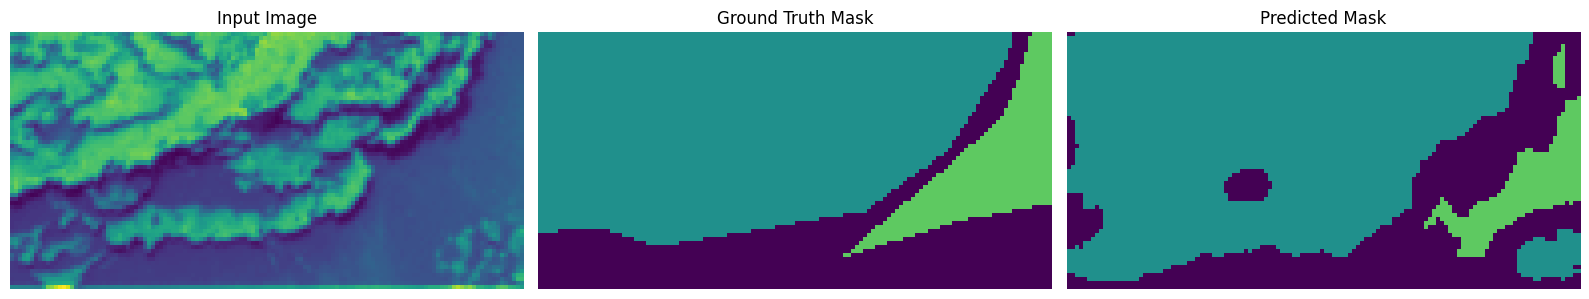

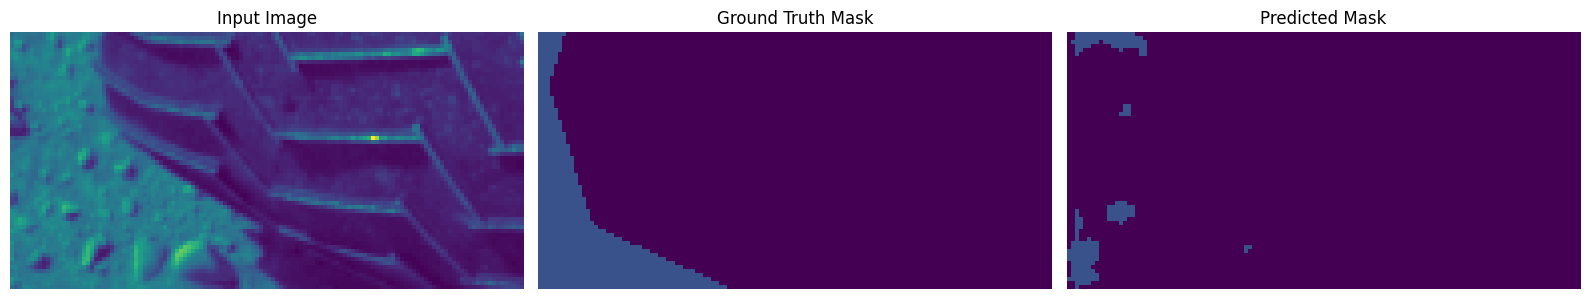

73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.8119 - loss: 0.1995 - mean_iou: 0.5761 - val_accuracy: 0.7316 - val_loss: 0.2981 - val_mean_iou: 0.4504 - learning_rate: 3.1250e-05
Epoch 118/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.8178 - loss: 0.1939 - mean_iou: 0.5831 - val_accuracy: 0.7303 - val_loss: 0.3099 - val_mean_iou: 0.4523 - learning_rate: 3.1250e-05
Epoch 119/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.8156 - loss: 0.1946 - mean_iou: 0.5856 - val_accuracy: 0.7592 - val_loss: 0.3111 - val_mean_iou: 0.4732 - learning_rate: 3.1250e-05
Epoch 120/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.8189 - loss: 0.1923 - mean_iou: 0.5884 - val_accuracy: 0.7260 - val_loss: 0.3381 - val_mean_iou: 0.4412 - learning_rate: 3.1250e-05
Epoch 121/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8210 - loss: 0.1901 - mean_iou: 0.5900

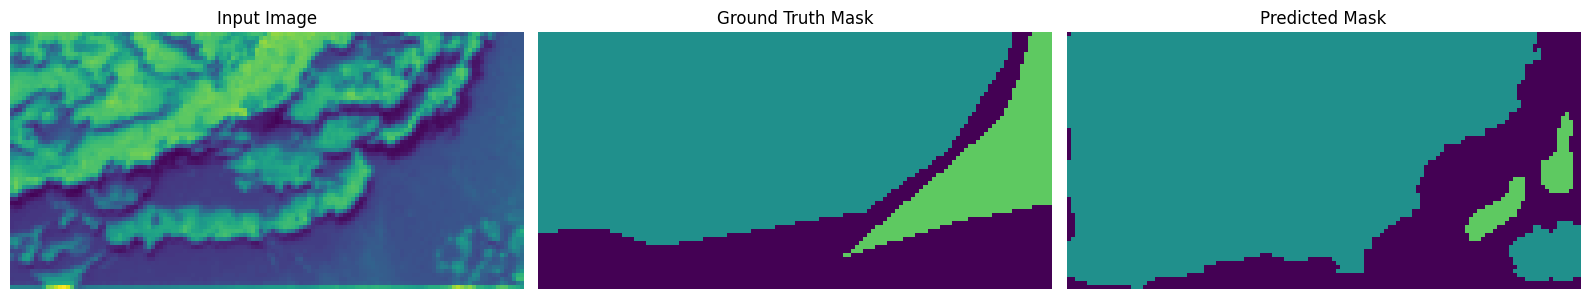

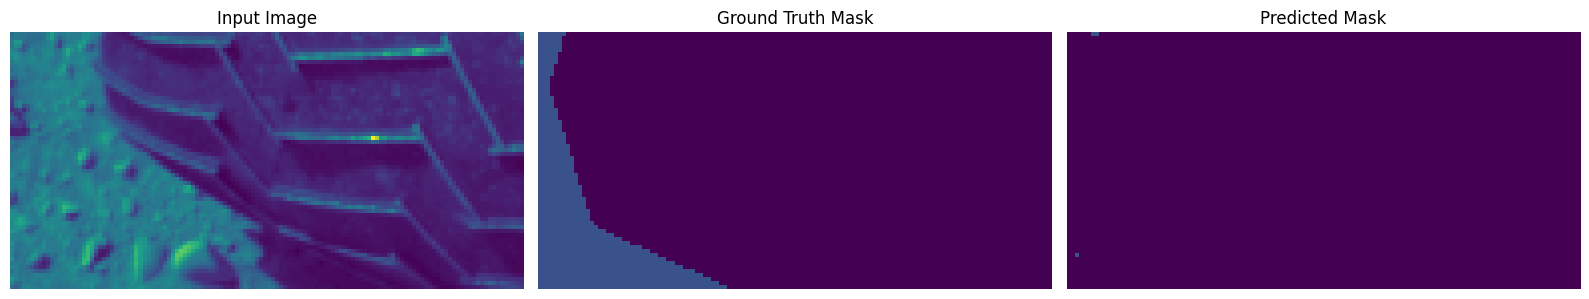

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.8210 - loss: 0.1901 - mean_iou: 0.5902 - val_accuracy: 0.7226 - val_loss: 0.3056 - val_mean_iou: 0.4354 - learning_rate: 3.1250e-05
Epoch 122/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.8245 - loss: 0.1858 - mean_iou: 0.5939 - val_accuracy: 0.7536 - val_loss: 0.2964 - val_mean_iou: 0.4629 - learning_rate: 1.5625e-05
Epoch 123/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.8273 - loss: 0.1818 - mean_iou: 0.5987 - val_accuracy: 0.7303 - val_loss: 0.3512 - val_mean_iou: 0.4341 - learning_rate: 1.5625e-05
Epoch 124/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.8331 - loss: 0.1761 - mean_iou: 0.6130 - val_accuracy: 0.7225 - val_loss: 0.3198 - val_mean_iou: 0.4412 - learning_rate: 1.5625e-05
Epoch 125/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8368 - loss: 0.1723 - mean_iou: 0.6179

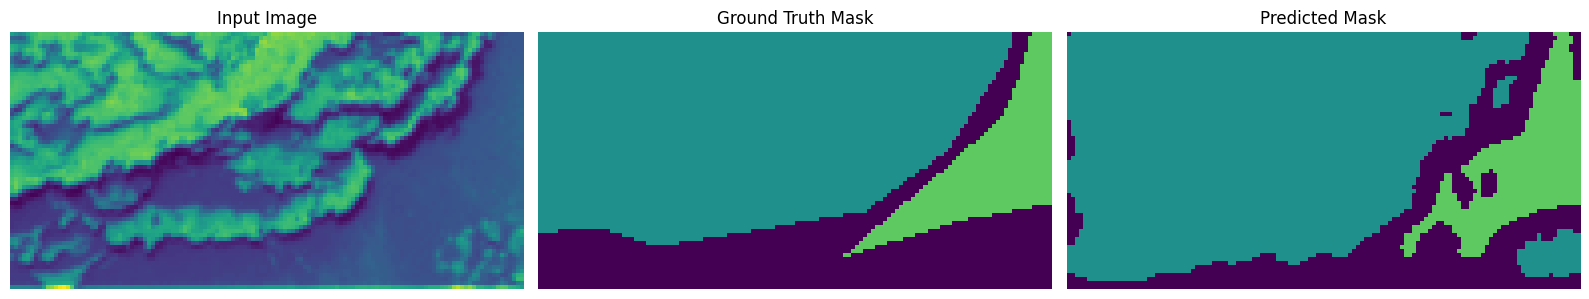

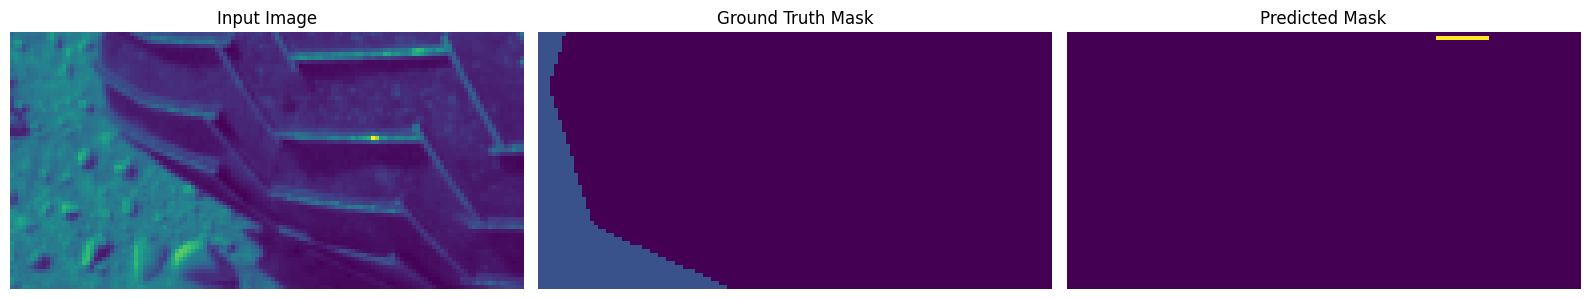

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.8368 - loss: 0.1723 - mean_iou: 0.6182 - val_accuracy: 0.7193 - val_loss: 0.3573 - val_mean_iou: 0.4239 - learning_rate: 1.5625e-05
Epoch 126/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.8373 - loss: 0.1724 - mean_iou: 0.6160 - val_accuracy: 0.7447 - val_loss: 0.3228 - val_mean_iou: 0.4442 - learning_rate: 1.5625e-05
Epoch 127/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.8409 - loss: 0.1681 - mean_iou: 0.6267 - val_accuracy: 0.7360 - val_loss: 0.3488 - val_mean_iou: 0.4369 - learning_rate: 1.5625e-05
Epoch 128/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.8439 - loss: 0.1653 - mean_iou: 0.6291 - val_accuracy: 0.7563 - val_loss: 0.2960 - val_mean_iou: 0.4667 - learning_rate: 1.5625e-05
Epoch 129/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8456 - loss: 0.1648 - mean_iou: 0.6306

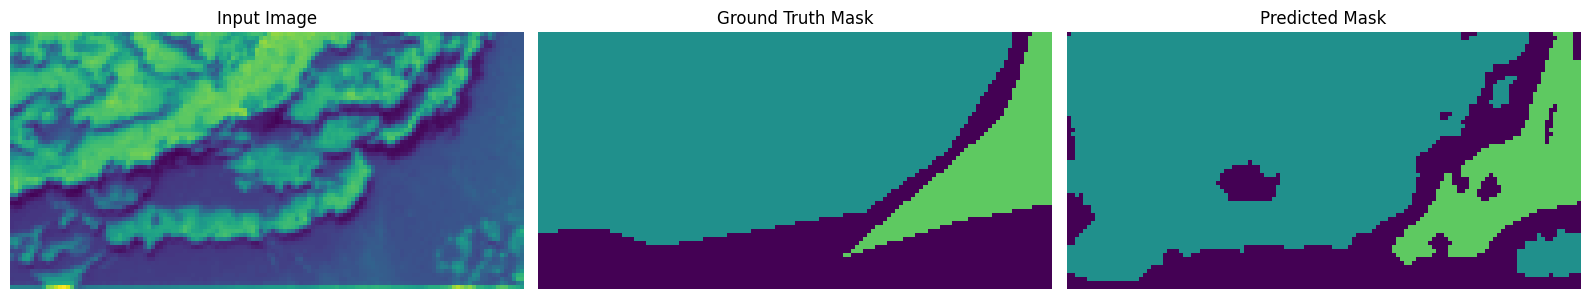

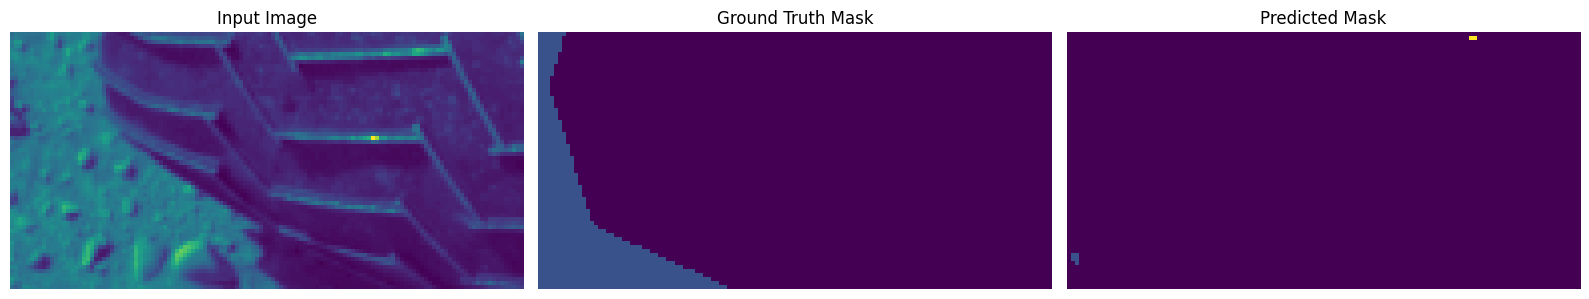

73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.8455 - loss: 0.1649 - mean_iou: 0.6309 - val_accuracy: 0.7639 - val_loss: 0.3164 - val_mean_iou: 0.4607 - learning_rate: 1.5625e-05
Epoch 130/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.8446 - loss: 0.1656 - mean_iou: 0.6226 - val_accuracy: 0.7550 - val_loss: 0.3130 - val_mean_iou: 0.4589 - learning_rate: 1.5625e-05
Epoch 131/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.8483 - loss: 0.1620 - mean_iou: 0.6315 - val_accuracy: 0.7670 - val_loss: 0.3213 - val_mean_iou: 0.4715 - learning_rate: 1.5625e-05
Epoch 132/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.8530 - loss: 0.1586 - mean_iou: 0.6411 - val_accuracy: 0.7592 - val_loss: 0.3528 - val_mean_iou: 0.4490 - learning_rate: 1.5625e-05
Epoch 133/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8532 - loss: 0.1575 - mean_iou: 0.6406

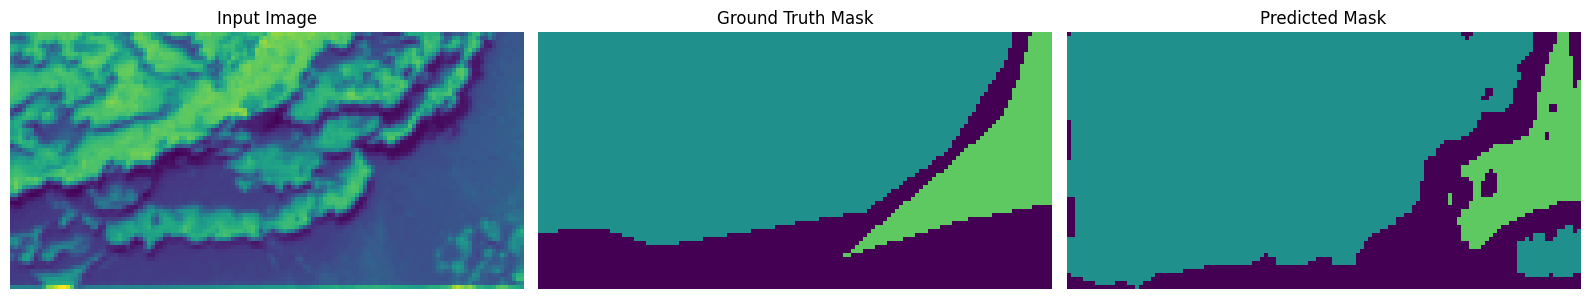

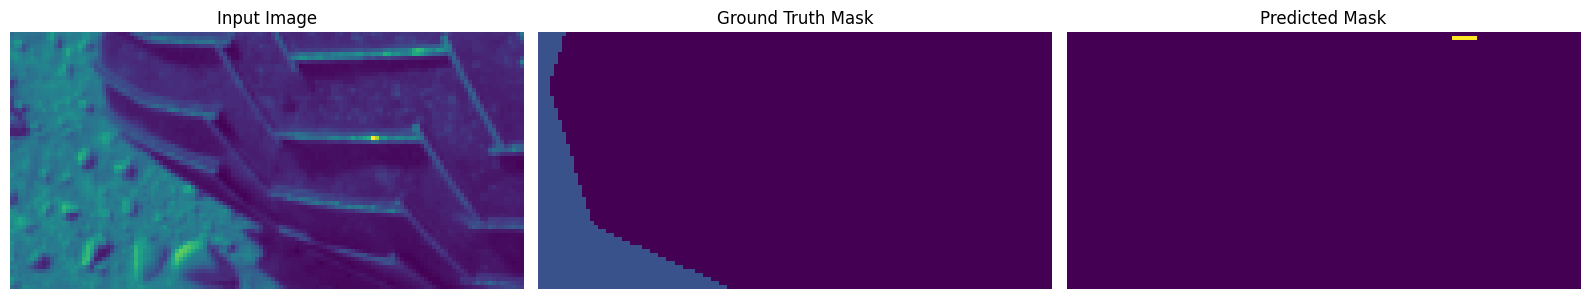

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.8532 - loss: 0.1575 - mean_iou: 0.6409 - val_accuracy: 0.7376 - val_loss: 0.3348 - val_mean_iou: 0.4359 - learning_rate: 1.5625e-05
Epoch 134/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.8571 - loss: 0.1551 - mean_iou: 0.6384 - val_accuracy: 0.7450 - val_loss: 0.3452 - val_mean_iou: 0.4364 - learning_rate: 7.8125e-06
Epoch 135/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.8581 - loss: 0.1531 - mean_iou: 0.6474 - val_accuracy: 0.7607 - val_loss: 0.3635 - val_mean_iou: 0.4582 - learning_rate: 7.8125e-06
Epoch 136/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.8637 - loss: 0.1495 - mean_iou: 0.6567 - val_accuracy: 0.7729 - val_loss: 0.3402 - val_mean_iou: 0.4701 - learning_rate: 7.8125e-06
Epoch 137/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8671 - loss: 0.1468 - mean_iou: 0.6557

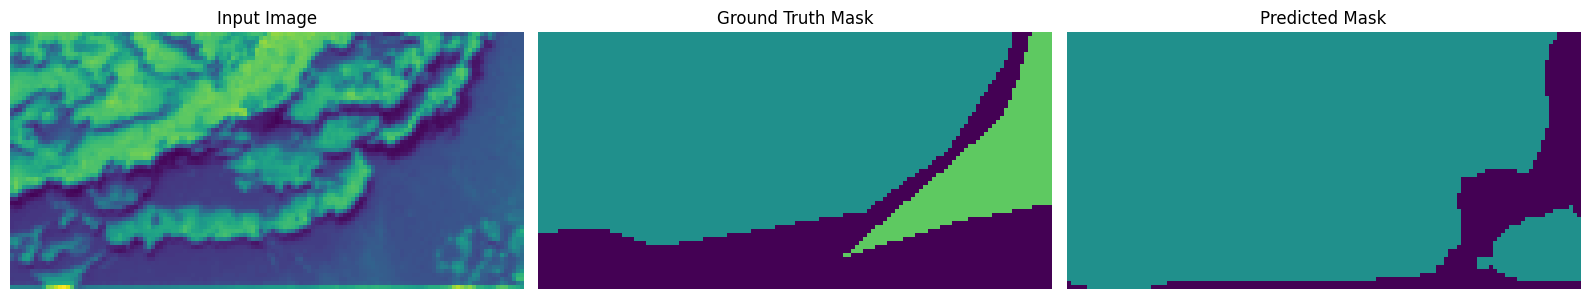

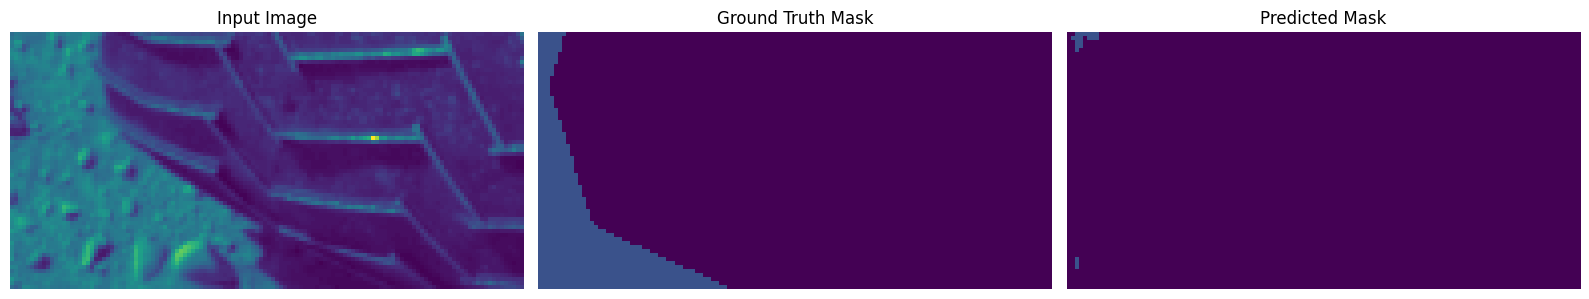

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.8670 - loss: 0.1469 - mean_iou: 0.6561 - val_accuracy: 0.7808 - val_loss: 0.3289 - val_mean_iou: 0.4792 - learning_rate: 7.8125e-06
Epoch 138/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.8694 - loss: 0.1446 - mean_iou: 0.6631 - val_accuracy: 0.7823 - val_loss: 0.3189 - val_mean_iou: 0.4849 - learning_rate: 7.8125e-06
Epoch 139/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.8710 - loss: 0.1431 - mean_iou: 0.6649 - val_accuracy: 0.7746 - val_loss: 0.3383 - val_mean_iou: 0.4701 - learning_rate: 7.8125e-06
Epoch 140/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.8732 - loss: 0.1418 - mean_iou: 0.6670 - val_accuracy: 0.7860 - val_loss: 0.3099 - val_mean_iou: 0.4834 - learning_rate: 7.8125e-06
Epoch 141/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8755 - loss: 0.1399 - mean_iou: 0.6750

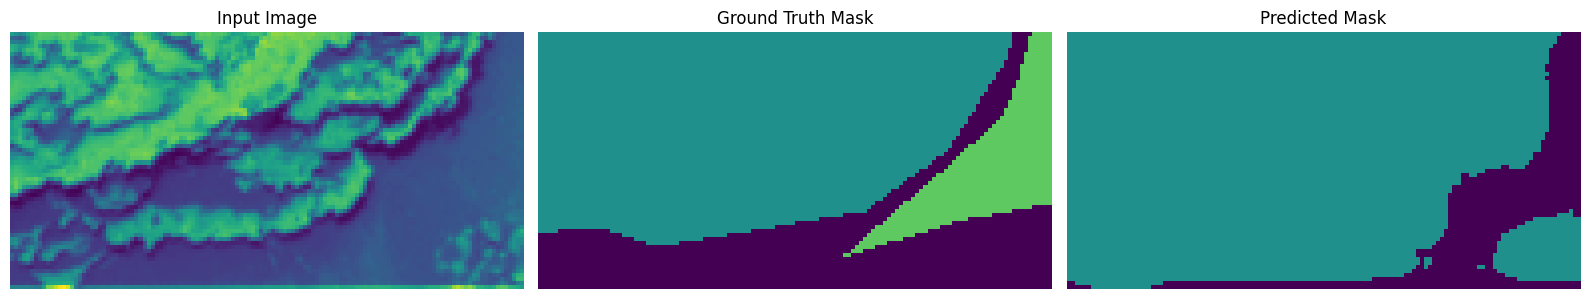

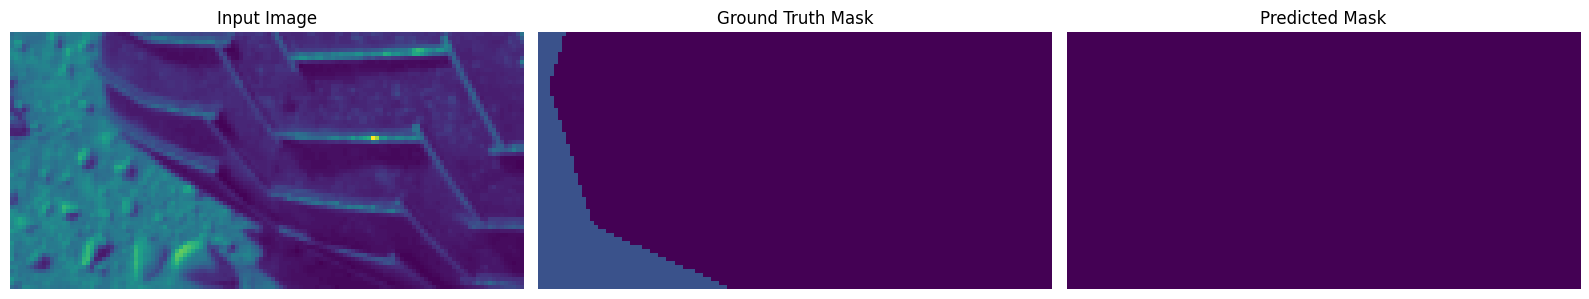

73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.8755 - loss: 0.1400 - mean_iou: 0.6752 - val_accuracy: 0.7610 - val_loss: 0.3214 - val_mean_iou: 0.4623 - learning_rate: 7.8125e-06
Epoch 142/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.8730 - loss: 0.1409 - mean_iou: 0.6720 - val_accuracy: 0.7874 - val_loss: 0.3001 - val_mean_iou: 0.4855 - learning_rate: 7.8125e-06
Epoch 143/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.8772 - loss: 0.1388 - mean_iou: 0.6714 - val_accuracy: 0.7756 - val_loss: 0.3100 - val_mean_iou: 0.4712 - learning_rate: 7.8125e-06
Epoch 144/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.8788 - loss: 0.1368 - mean_iou: 0.6809 - val_accuracy: 0.7927 - val_loss: 0.3069 - val_mean_iou: 0.5001 - learning_rate: 7.8125e-06
Epoch 145/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8793 - loss: 0.1357 - mean_iou: 0.6815

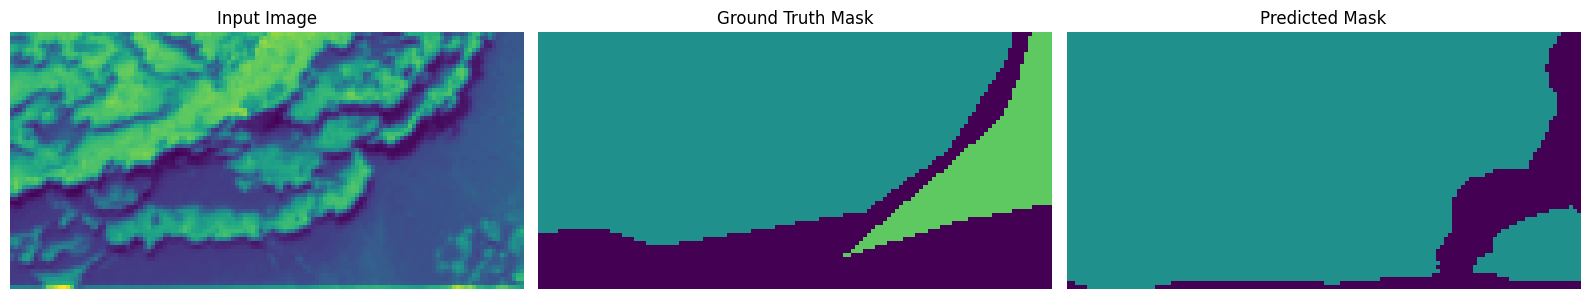

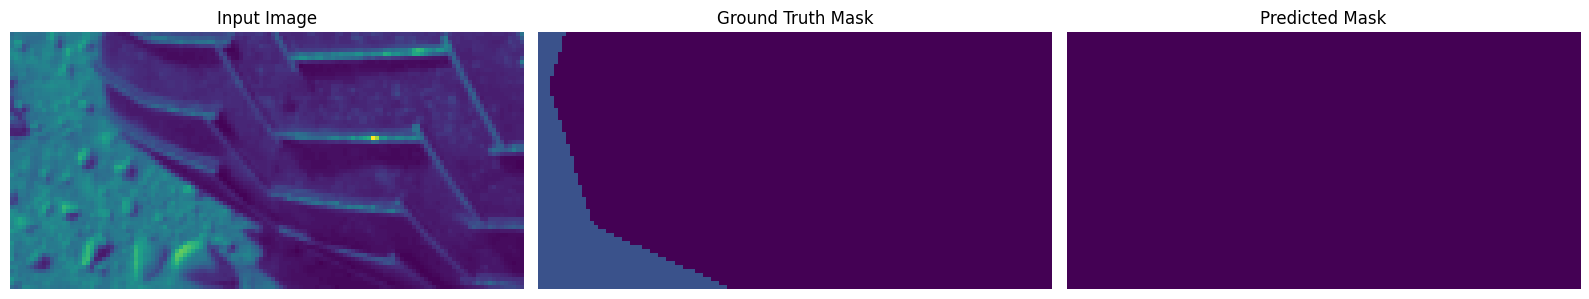

73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.8792 - loss: 0.1358 - mean_iou: 0.6817 - val_accuracy: 0.7682 - val_loss: 0.3174 - val_mean_iou: 0.4760 - learning_rate: 7.8125e-06
Epoch 146/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.8820 - loss: 0.1352 - mean_iou: 0.6821 - val_accuracy: 0.7856 - val_loss: 0.2980 - val_mean_iou: 0.4899 - learning_rate: 7.8125e-06
Epoch 147/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.8844 - loss: 0.1333 - mean_iou: 0.6882 - val_accuracy: 0.5561 - val_loss: 0.4519 - val_mean_iou: 0.2863 - learning_rate: 7.8125e-06
Epoch 148/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.8789 - loss: 0.1361 - mean_iou: 0.6864 - val_accuracy: 0.7787 - val_loss: 0.2979 - val_mean_iou: 0.4920 - learning_rate: 7.8125e-06
Epoch 149/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8860 - loss: 0.1311 - mean_iou: 0.6846

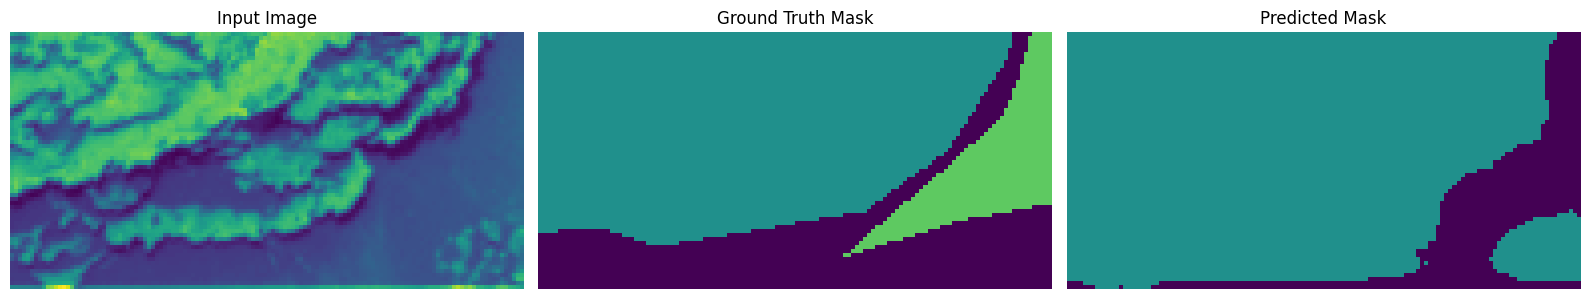

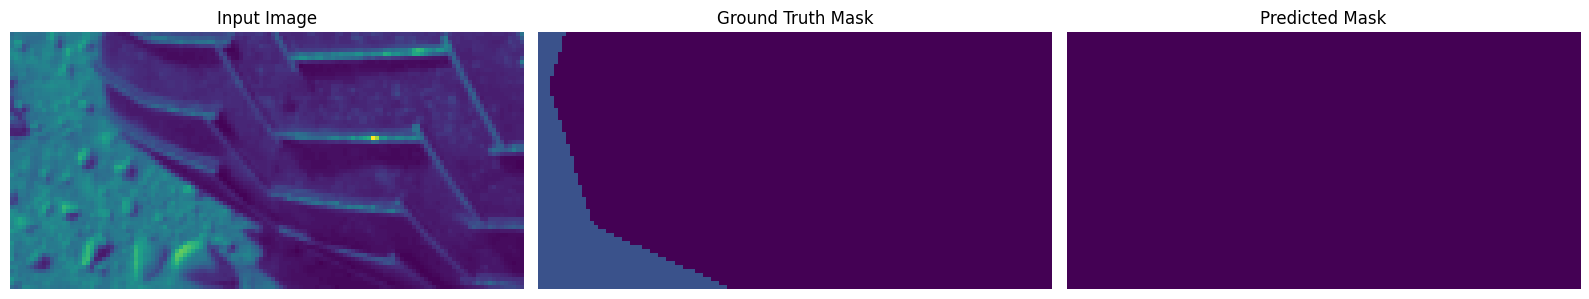

73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.8859 - loss: 0.1312 - mean_iou: 0.6848 - val_accuracy: 0.7822 - val_loss: 0.3280 - val_mean_iou: 0.4817 - learning_rate: 7.8125e-06
Epoch 150/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.8881 - loss: 0.1295 - mean_iou: 0.6903 - val_accuracy: 0.7731 - val_loss: 0.3166 - val_mean_iou: 0.4813 - learning_rate: 7.8125e-06
Epoch 151/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.8908 - loss: 0.1282 - mean_iou: 0.6889 - val_accuracy: 0.7817 - val_loss: 0.3260 - val_mean_iou: 0.4924 - learning_rate: 7.8125e-06
Epoch 152/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.8906 - loss: 0.1283 - mean_iou: 0.6863 - val_accuracy: 0.7402 - val_loss: 0.3301 - val_mean_iou: 0.4390 - learning_rate: 7.8125e-06
Epoch 153/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8895 - loss: 0.1285 - mean_iou: 0.6915

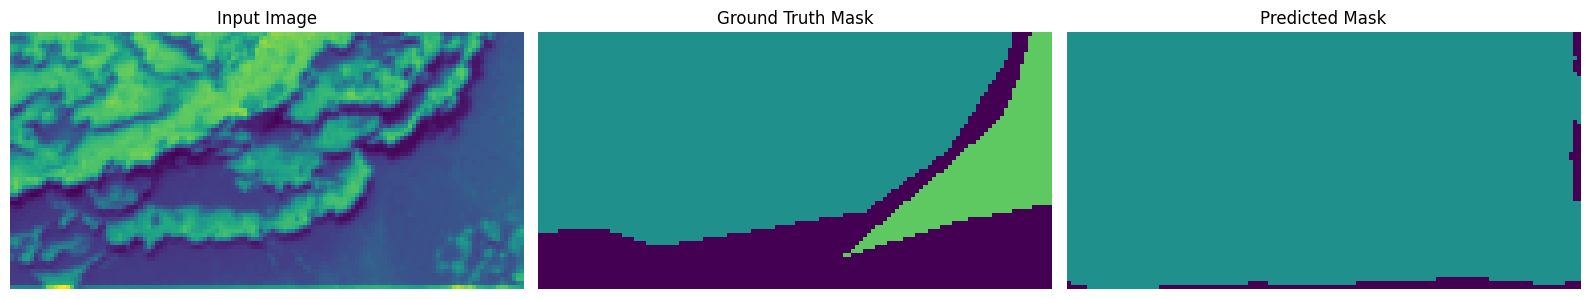

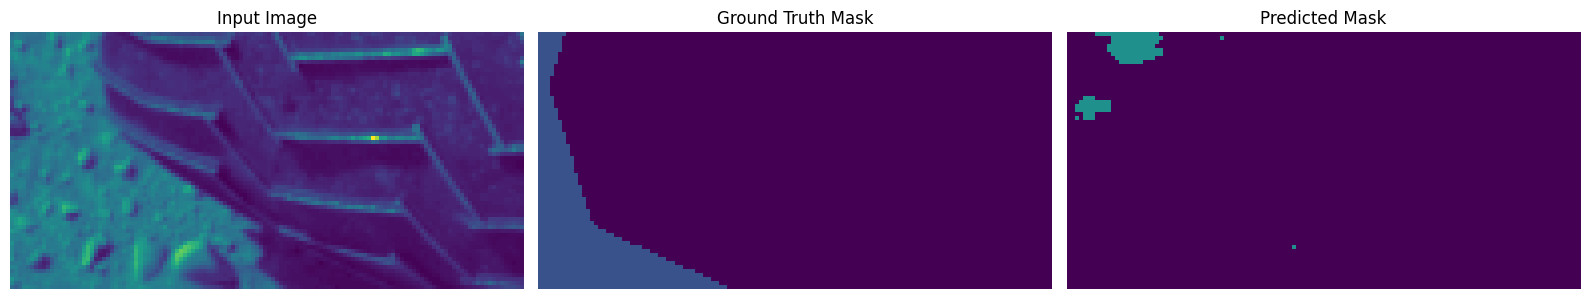

73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.8895 - loss: 0.1285 - mean_iou: 0.6917 - val_accuracy: 0.7677 - val_loss: 0.3293 - val_mean_iou: 0.4884 - learning_rate: 7.8125e-06
Epoch 154/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.8928 - loss: 0.1279 - mean_iou: 0.6814 - val_accuracy: 0.7744 - val_loss: 0.3530 - val_mean_iou: 0.4745 - learning_rate: 7.8125e-06
Epoch 155/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.8947 - loss: 0.1254 - mean_iou: 0.6902 - val_accuracy: 0.7591 - val_loss: 0.3479 - val_mean_iou: 0.4635 - learning_rate: 7.8125e-06
Epoch 156/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.8975 - loss: 0.1235 - mean_iou: 0.6873 - val_accuracy: 0.7606 - val_loss: 0.3372 - val_mean_iou: 0.4657 - learning_rate: 7.8125e-06
Epoch 157/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8978 - loss: 0.1232 - mean_iou: 0.6986

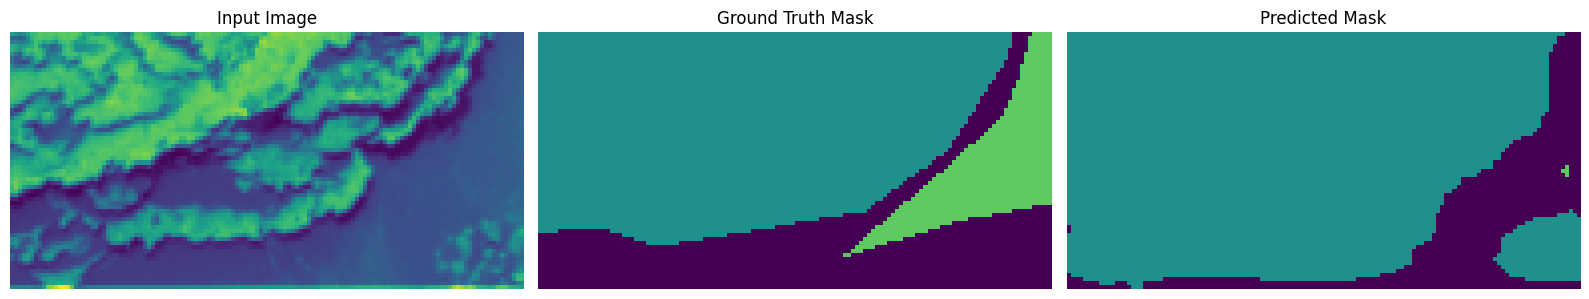

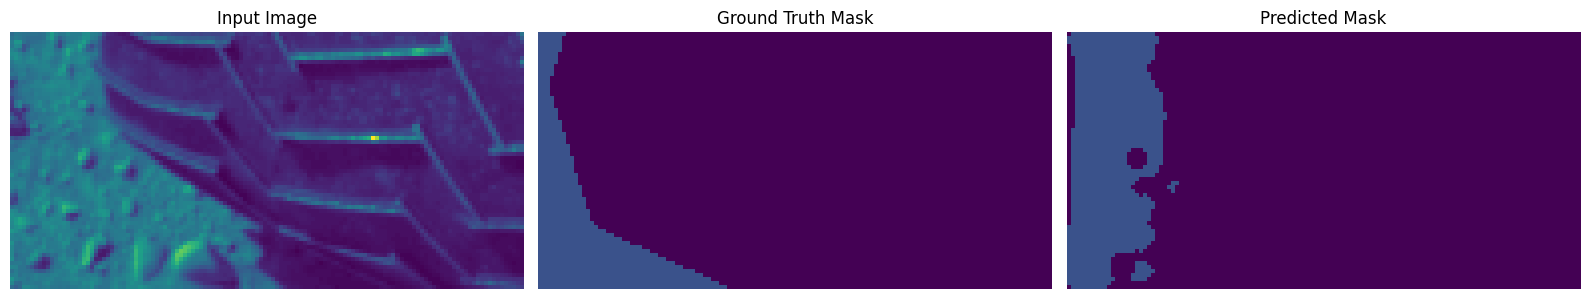

73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.8978 - loss: 0.1232 - mean_iou: 0.6988 - val_accuracy: 0.7623 - val_loss: 0.3572 - val_mean_iou: 0.4681 - learning_rate: 3.9063e-06
Epoch 158/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.8973 - loss: 0.1232 - mean_iou: 0.6979 - val_accuracy: 0.7775 - val_loss: 0.3732 - val_mean_iou: 0.4780 - learning_rate: 3.9063e-06
Epoch 159/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.8992 - loss: 0.1218 - mean_iou: 0.6969 - val_accuracy: 0.7687 - val_loss: 0.3771 - val_mean_iou: 0.4714 - learning_rate: 3.9063e-06
Epoch 160/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.9016 - loss: 0.1200 - mean_iou: 0.7038 - val_accuracy: 0.7668 - val_loss: 0.3715 - val_mean_iou: 0.4744 - learning_rate: 3.9063e-06
Epoch 161/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9039 - loss: 0.1183 - mean_iou: 0.7061

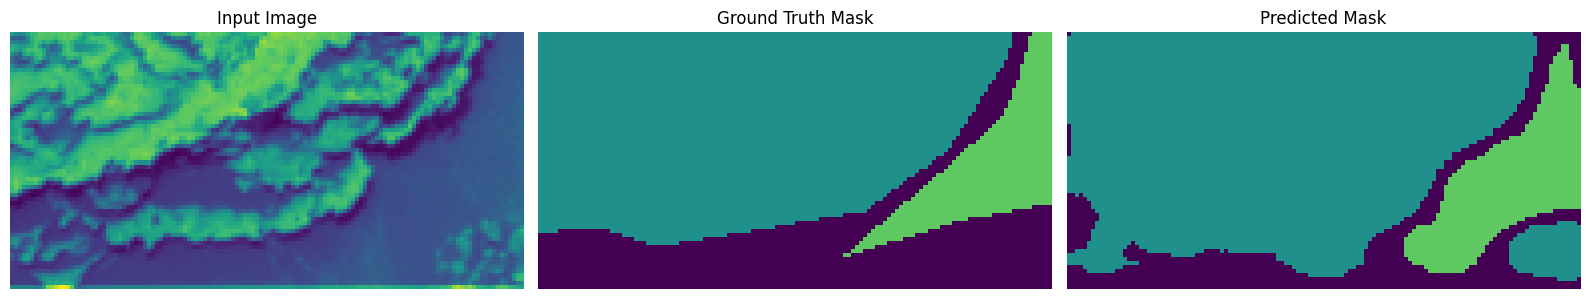

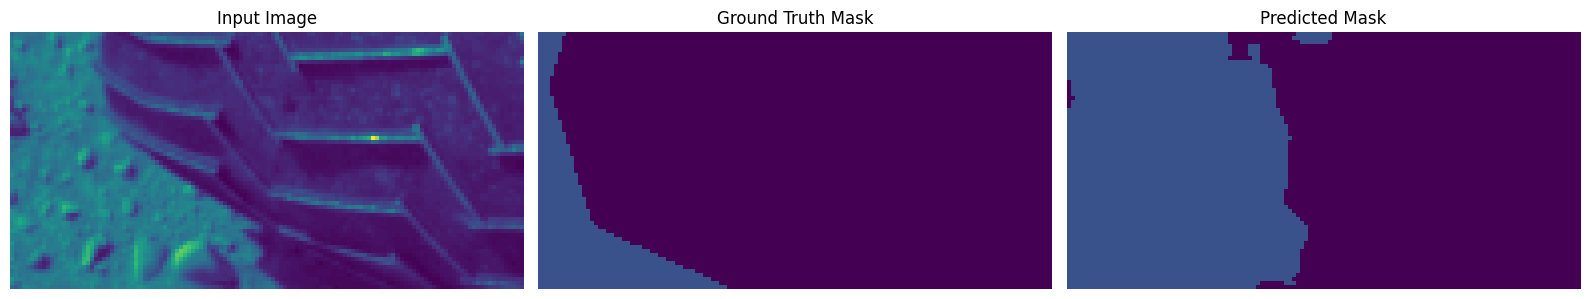

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - accuracy: 0.9038 - loss: 0.1183 - mean_iou: 0.7064 - val_accuracy: 0.7589 - val_loss: 0.3721 - val_mean_iou: 0.4754 - learning_rate: 3.9063e-06
Epoch 162/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.9053 - loss: 0.1171 - mean_iou: 0.7108 - val_accuracy: 0.7561 - val_loss: 0.3767 - val_mean_iou: 0.4707 - learning_rate: 3.9063e-06
Epoch 163/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.9070 - loss: 0.1159 - mean_iou: 0.7092 - val_accuracy: 0.7524 - val_loss: 0.3813 - val_mean_iou: 0.4737 - learning_rate: 3.9063e-06
Epoch 164/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.9081 - loss: 0.1150 - mean_iou: 0.7123 - val_accuracy: 0.7366 - val_loss: 0.3845 - val_mean_iou: 0.4612 - learning_rate: 3.9063e-06
Epoch 165/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9093 - loss: 0.1141 - mean_iou: 0.7148

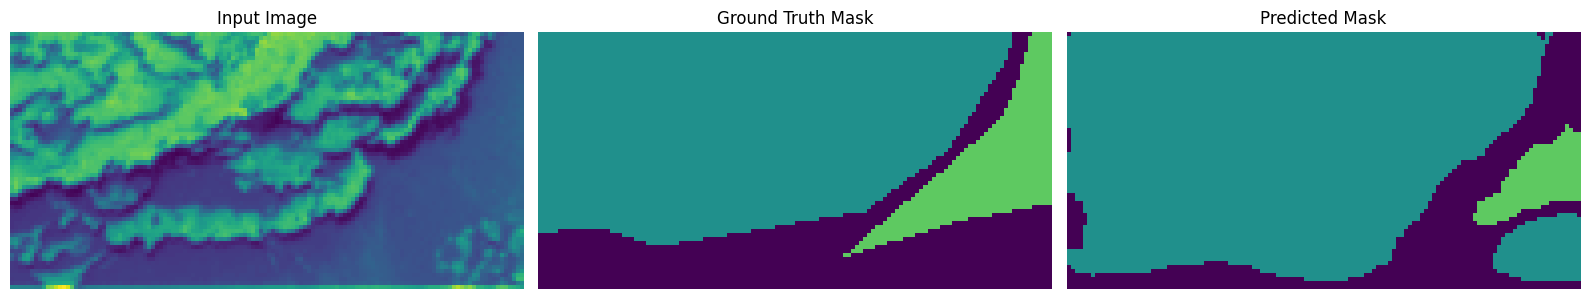

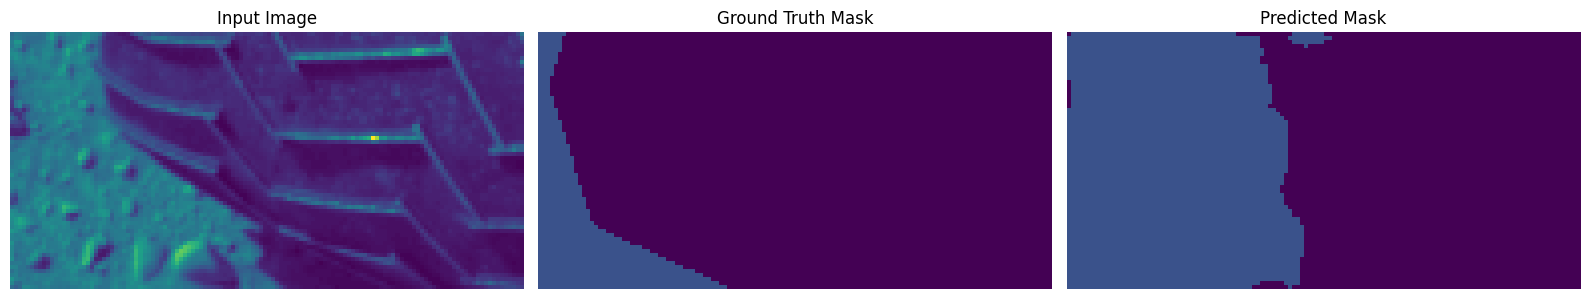

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.9093 - loss: 0.1141 - mean_iou: 0.7150 - val_accuracy: 0.7266 - val_loss: 0.4088 - val_mean_iou: 0.4521 - learning_rate: 3.9063e-06
Epoch 166/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.9098 - loss: 0.1136 - mean_iou: 0.7149 - val_accuracy: 0.6758 - val_loss: 0.3978 - val_mean_iou: 0.4261 - learning_rate: 3.9063e-06
Epoch 167/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.9105 - loss: 0.1132 - mean_iou: 0.7121 - val_accuracy: 0.6921 - val_loss: 0.4181 - val_mean_iou: 0.4264 - learning_rate: 3.9063e-06
Epoch 168/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.9102 - loss: 0.1128 - mean_iou: 0.7130 - val_accuracy: 0.5707 - val_loss: 0.4184 - val_mean_iou: 0.3601 - learning_rate: 3.9063e-06
Epoch 169/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9094 - loss: 0.1135 - mean_iou: 0.7156

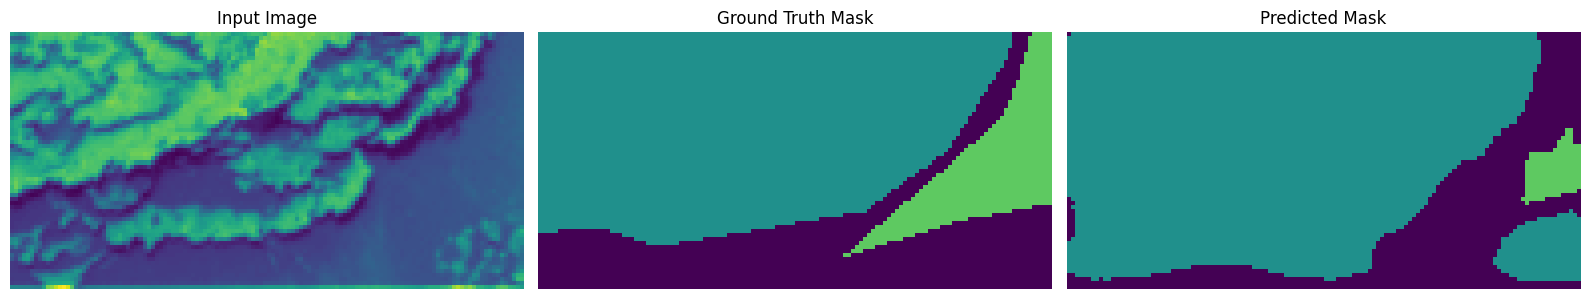

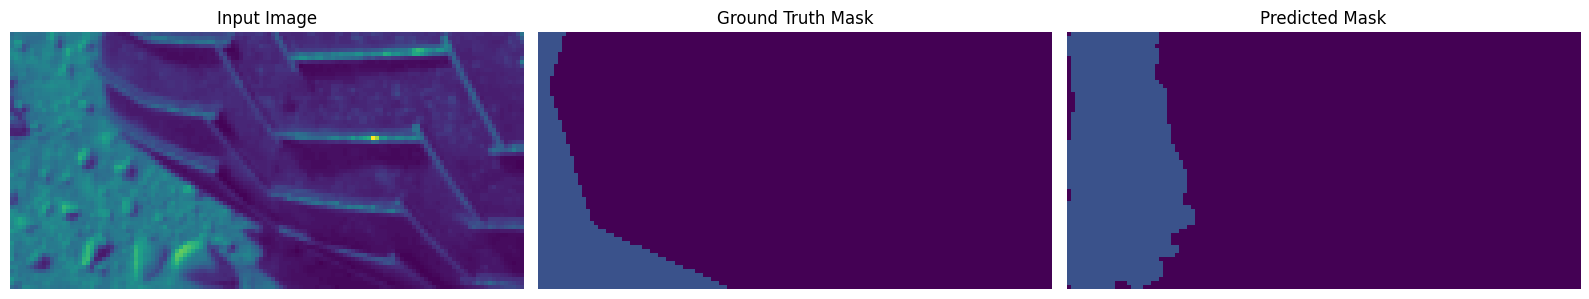

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.9094 - loss: 0.1135 - mean_iou: 0.7158 - val_accuracy: 0.7821 - val_loss: 0.3535 - val_mean_iou: 0.4847 - learning_rate: 1.9531e-06
Epoch 170/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.9116 - loss: 0.1120 - mean_iou: 0.7138 - val_accuracy: 0.7887 - val_loss: 0.3550 - val_mean_iou: 0.4873 - learning_rate: 1.9531e-06
Epoch 171/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.9145 - loss: 0.1100 - mean_iou: 0.7215 - val_accuracy: 0.7821 - val_loss: 0.3610 - val_mean_iou: 0.4797 - learning_rate: 1.9531e-06
Epoch 172/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.9162 - loss: 0.1090 - mean_iou: 0.7320 - val_accuracy: 0.7800 - val_loss: 0.3673 - val_mean_iou: 0.4750 - learning_rate: 1.9531e-06
Epoch 173/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9175 - loss: 0.1081 - mean_iou: 0.7248

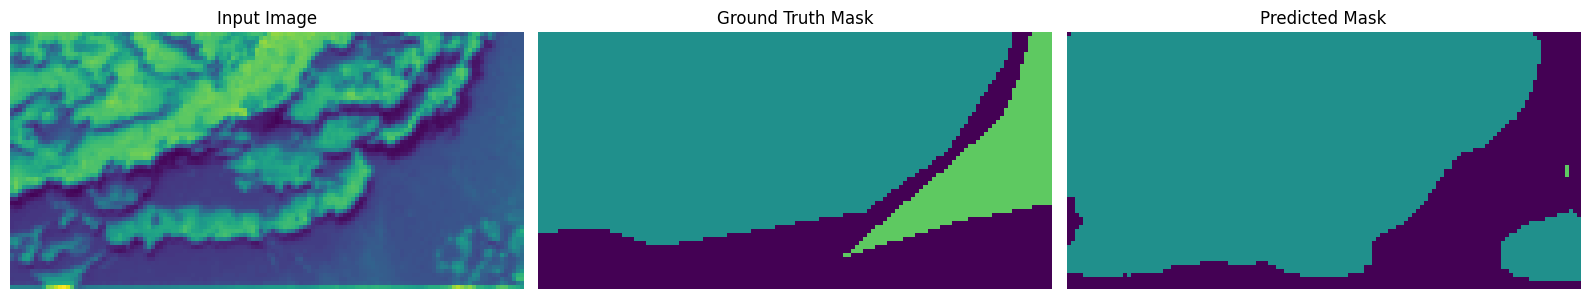

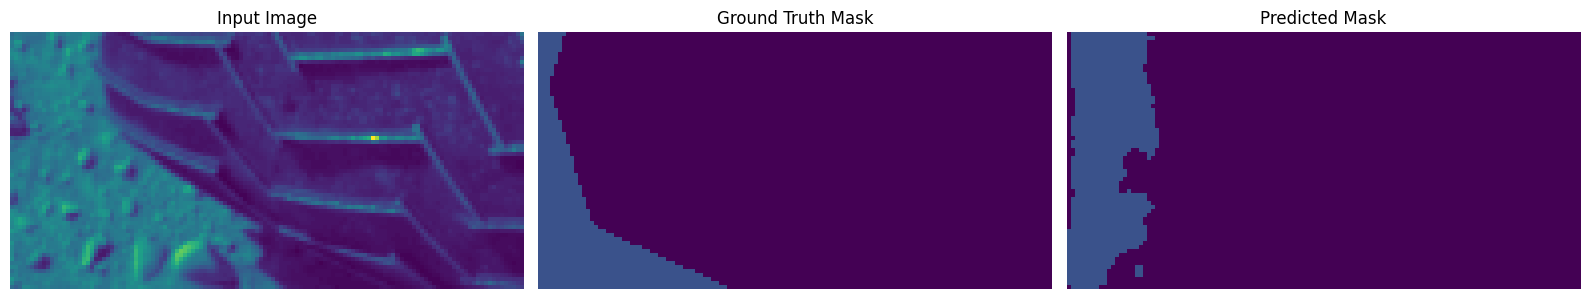

73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.9175 - loss: 0.1081 - mean_iou: 0.7250 - val_accuracy: 0.7745 - val_loss: 0.3749 - val_mean_iou: 0.4683 - learning_rate: 1.9531e-06
Epoch 174/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.9187 - loss: 0.1073 - mean_iou: 0.7295 - val_accuracy: 0.7748 - val_loss: 0.3725 - val_mean_iou: 0.4680 - learning_rate: 1.9531e-06
Epoch 175/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.9196 - loss: 0.1067 - mean_iou: 0.7276 - val_accuracy: 0.7711 - val_loss: 0.3799 - val_mean_iou: 0.4640 - learning_rate: 1.9531e-06
Epoch 176/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.9208 - loss: 0.1059 - mean_iou: 0.7307 - val_accuracy: 0.7708 - val_loss: 0.3781 - val_mean_iou: 0.4643 - learning_rate: 1.9531e-06
Epoch 177/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9219 - loss: 0.1053 - mean_iou: 0.7293

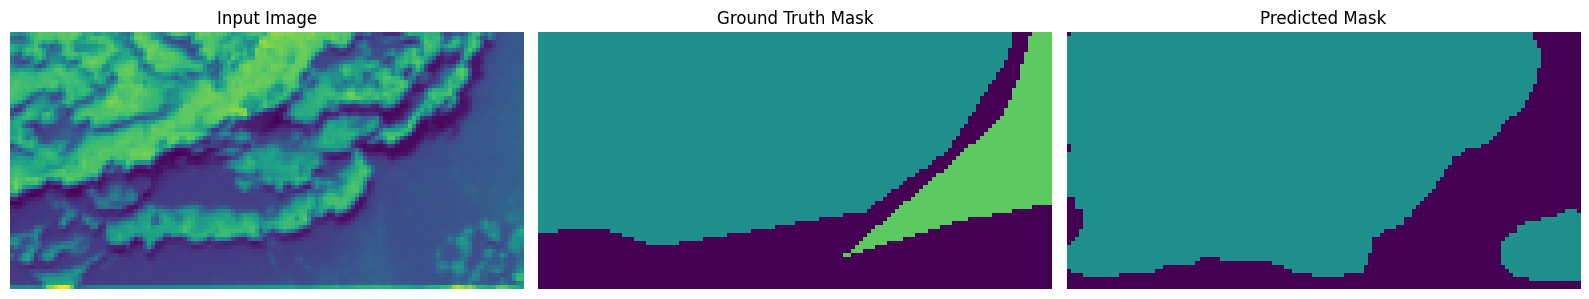

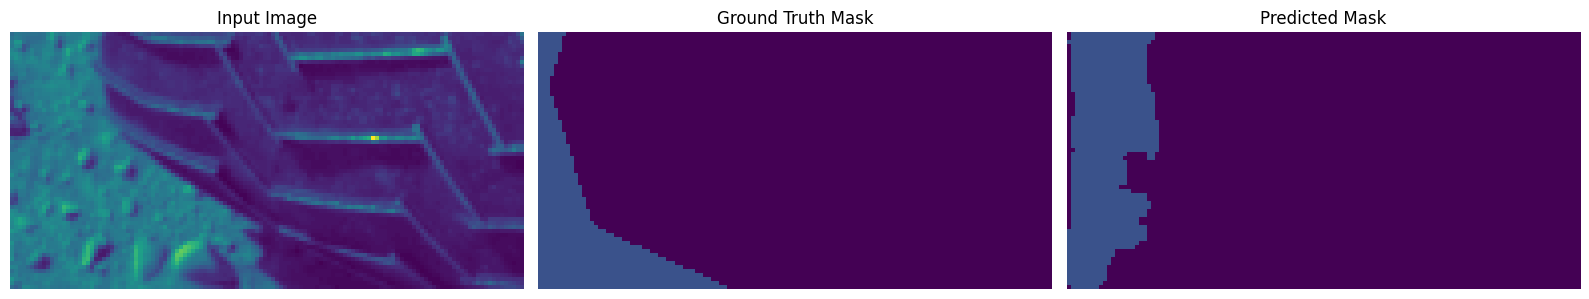

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - accuracy: 0.9219 - loss: 0.1053 - mean_iou: 0.7295 - val_accuracy: 0.7653 - val_loss: 0.3887 - val_mean_iou: 0.4587 - learning_rate: 1.9531e-06
Epoch 178/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.9227 - loss: 0.1047 - mean_iou: 0.7347 - val_accuracy: 0.7618 - val_loss: 0.3869 - val_mean_iou: 0.4563 - learning_rate: 1.9531e-06
Epoch 179/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.9239 - loss: 0.1039 - mean_iou: 0.7361 - val_accuracy: 0.7611 - val_loss: 0.3909 - val_mean_iou: 0.4557 - learning_rate: 1.9531e-06
Final validation Mean Intersection Over Union: 50.01%


In [ ]:
# Train the model
history2 = model2.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    validation_data=(X_val,y_val),
    callbacks=[early_stopping, viz_callback1, viz_callback2, tfk.callbacks.ReduceLROnPlateau(monitor='val_mean_iou', mode='max',factor=0.5, patience=12, min_delta=1e-4)],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history2['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model2_{timestep_str}.keras"
model2.save(model_filename)

# Delete the model to free up resources

In [ ]:
# Predictions on the test set
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

In [ ]:
# Define a function for post-processing

import numpy as np
from scipy.ndimage import distance_transform_edt

def assegnare_valore_vicino_batch(predictions):
    # For every sample in the batch, apply the "propagation logic"

    risultati = []
    for matrice in predictions:
        # Find the pixel with label 0
        mask_zero = (matrice == 0)

        # Calculate the Euclidean distance from not-zero pixels and get the indexes of the closest ones
        dist, indices = distance_transform_edt(mask_zero, return_indices=True)

        # Find the labels of such pixels
        valori_propagati = matrice[tuple(indices)]

        # Replace the zeros
        matrice_risultante = matrice.copy()
        condizione = (mask_zero)
        matrice_risultante[condizione] = valori_propagati[condizione]

        # Add the matrix to the list
        risultati.append(matrice_risultante)

    # Create a NumPy array
    return np.array(risultati)



# Apply the function
ris = assegnare_valore_vicino_batch(preds1)
print("Forma dei risultati:", ris.shape)


Forma dei risultati: (10022, 64, 128)


In [ ]:
# Set labels to 4 when the label of the image is all 0
ris[ris==0]=4

In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str ='11dicprova1no4'
 #model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(ris)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>